# Optimizing the Image Sampling

<div class="alert-danger">Note: The notebook in this repository 'Initialization.ipynb' goes over many of the basic concepts such as the setup of the environment/package installation and should be read first if you are new to HST images, DrizzlePac, or Astroquery.</div>

## Introduction

This example was written to help users better understand the subtleties in improving image sampling for dithered data. One of the powers of the *drizzling* algorithm is that, given properly dithered images, it can restore much of the information lost due to undersampled images ([Fruchter and Hook, 2002](http://iopscience.iop.org/article/10.1086/338393/pdf)). 

This work is based on [ISR ACS 2015-01](http://www.stsci.edu/hst/acs/documents/isrs/isr1501.pdf), which contains a more detailed discussion than presented here.

In practice, this requires the use of `Astrodrizzle` task within the *Drizzlepac* package. This example will cover the following topics:

    1. Description of the Data
    2. Run astrodrizzle several times using different settings for the 'final_pixfrac' and 'final_scale' parameters
    3. Compare and evaluate results of using different 'final_pixfrac' and 'final_scale' values

In [1]:
import glob
import shutil
import os

from astropy.io import fits
from astroquery.mast import Observations
from astropy.visualization import LogStretch,ImageNormalize,LinearStretch
from astropy import wcs
import drizzlepac
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    


The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


## 1. Description of the data
Four images of the spiral galaxy NGC 3370 (Program 11570) were acquired using the WFC3/IR F160W imaging filter. The `WFC3-IR-DITHERBOX-MIN` dither pattern designed to provide optimal sampling of the PSF was used.

Data are downloaded using the `astroquery` API to access the [MAST](http://archive.stsci.edu) archive. The `astroquery.mast` [documentation](http://astroquery.readthedocs.io/en/latest/mast/mast.html) has more examples for how to find and download data from MAST. For this example, the caibrated FLT exposures from visit 19 will be downloaded.

In [2]:
# Querying MAST and downloading files.
obs_ids = ['ib1f19010']
obs_table = Observations.query_criteria(obs_id=obs_ids, obstype='all')

download_tab = Observations.download_products(obs_table['obsid'], mrp_only=False, productSubGroupDescription=['FLT'])

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


In [3]:
# Cleaning up directories after dowloading from MAST
for file in download_tab['Local Path']:
    os.rename(file, os.path.basename(file))
        
shutil.rmtree('mastDownload')

## 2. Dithering
For the *drizzle* algorithm to work optimally, observations need to be dithered so that the PSF is optimally sampled. The code below creates plots to show the dithering of each of the images in the association. The plot on the left shows how the images were dithered on the sky (the POSTARG). The plot on the right shows how the offsets translate to pixel phase (e.g. subpixel position). 

Plate scale: 0.1283


Text(0, 0.5, 'Y pixel phase')

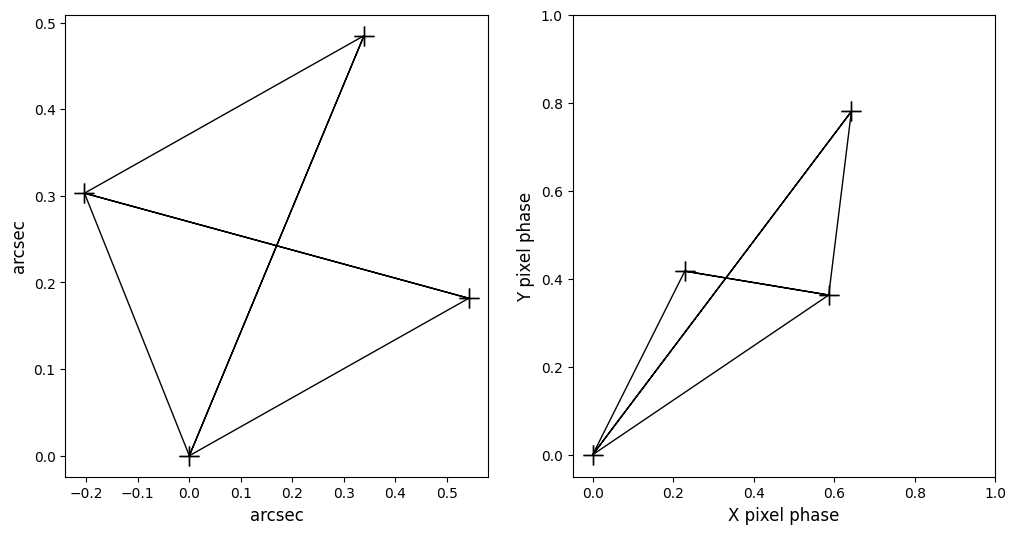

In [4]:
flt_files = glob.glob('*flt.fits')

plate_scale = fits.getval(flt_files[0], 'idcscale',ext=1)
print('Plate scale: {:>6.4f}'.format(plate_scale))
postarg1 = np.empty(len(flt_files), dtype=np.float)
postarg2 = np.empty(len(flt_files), dtype=np.float)
x_phase = np.empty(len(flt_files), dtype=np.float)
y_phase = np.empty(len(flt_files), dtype=np.float)

for i, im in enumerate(flt_files):
    with fits.open(im) as hdu:
        postarg1[i] = hdu[0].header['postarg1']
        postarg2[i] = hdu[0].header['postarg2']
        x_phase[i] = abs(np.modf(postarg1[i] / plate_scale)[0])
        y_phase[i] = abs(np.modf(postarg2[i] / plate_scale)[0])
        
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(postarg1, postarg2, 'k+-', ms=15, lw=1)
ax[0].set_xlabel('arcsec', fontsize='large')
ax[0].set_ylabel('arcsec', fontsize='large')

ax[1].plot(x_phase, y_phase, 'k+-', ms=15, lw=1)
ax[1].set_xlim(-0.05, 1)
ax[1].set_ylim(-0.05, 1)
ax[1].set_xlabel('X pixel phase', fontsize='large')
ax[1].set_ylabel('Y pixel phase', fontsize='large')

## 3. Drizzling
Before drizzling can be performed, a plate scale for the output image should be chosen. This will usually be dictated by the science needs. In theory, critical sampling of a PSF occurs with 2.355 pixels. The FWHM of the WFC3/IR detector at 1600 nm is ~0.151" (Table 7.5 of [WFC Instrument Handbook](http://www.stsci.edu/hst/wfc3/documents/handbooks/currentIHB/c07_ir07.html)). Using these values, a plate scale of 0.065"/pix will be selected for the drizzled output frame, approximately half of the native plate scale (0.1283"/pix). 

The mechanism by which the *drizzle* algorithm improves sampling in the output image is by shrinking the input pixels before adding them to the output pixel grid (see Figure 2 in [Fruchter and Hook (2002)](http://iopscience.iop.org/article/10.1086/338393/pdf)). In practice this process is controlled in the `AstroDrizzle` package by adjusting the `final_pixfrac` parameter, which is the fractional size of the pixel to be used. 
Below `AstroDrizzle` is called twice. The first time, no changes are made to the plate scale or the size of the drop. In the second call, the plate scale and pixfrac are reduced. For a four point dither stack, a `final_pixfrac` value of 0.8 is usually optimal.

In [5]:
drizzlepac.astrodrizzle.AstroDrizzle('*flt.fits',
                                     output='f160w_noopt',
                                     runfile='',
                                     context=False,
                                     build=True,
                                     preserve=False,
                                     clean=True,
                                     driz_sep_bits='64,512',
                                     final_bits='64,512',
                                     final_wcs=True,
                                     final_rot=0.)

drizzlepac.astrodrizzle.AstroDrizzle('*flt.fits',
                                     output='f160w_opt',
                                     runfile='',
                                     context=False,
                                     build=True,
                                     preserve=False,
                                     clean=True,
                                     driz_sep_bits='64,512',
                                     final_bits='64,512',
                                     final_pixfrac=0.8,
                                     final_wcs=True,
                                     final_rot=0.,
                                     final_scale=0.065)

No trailer file created...
AstroDrizzle log file: final.tra
AstroDrizzle Version 3.5.1 started at: 16:51:01.496 (19/04/2024)

==== Processing Step  Initialization  started at  16:51:01.496 (19/04/2024)



##############################################################################
#                                                                            #
# “minmed” is highly recommended for three images,                           #
#  and is good for four to six images,                                       #
#  but should be avoided for ten or more images.                             #
#                                                                            #
##############################################################################


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 591.9026595870587  535.72854962001  
CD1_1 CD1_2  : -3.562500079472858e-05  1.7530017893904253e-22  
CD2_1 CD2_2  : -1.241796017022117e-25  3.562500079472858e-05  
NAXIS : 1184  1072
********************************************************************************
*
*  Estimated memory usage:  up to 89 Mb.
*  Output image size:       1184 X 1072 pixels. 
*  Output image file:       ~ 14 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step Initialization finished at 16:51:02.631 (19/04/2024)


==== Processing Step  Static Mask  started at  16:51:02.632 (19/04/2024)



==== Processing Step Static Mask finished at 16:51:02.75 (19/04/2024)


==== Processing Step  Subtract Sky  started at  16:51:02.757 (19/04/2024)



***** skymatch started on 2024-04-19 16:51:02.856490
      Version 1.0.9

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l6_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l7_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l9_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits'


       EXT = 'SCI',1
             Data units type: COUNT-RATE
             Conversion factor (data->brightness):  60.797431635711504




-----  Computing sky values requested image extensions (detector chips):  -----

   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits['SCI',1]'  --  SKY = 56.203832965924214 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.924444   NEW MDRIZSKY = 0.924444
   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits['SCI',1]'  --  SKY = 52.8972627889636 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.870058   NEW MDRIZSKY = 0.870058


   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits['SCI',1]'  --  SKY = 51.619641705121005 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.849043   NEW MDRIZSKY = 0.849043
   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits['SCI',1]'  --  SKY = 51.32938907415446 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.844269   NEW MDRIZSKY = 0.844269
   *   Image:   'ib1f19l6q_flt.fits['SCI',1]'  --  SKY = 56.203832965924214 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.924444   NEW MDRIZSKY = 0.924444


   *   Image:   'ib1f19l7q_flt.fits['SCI',1]'  --  SKY = 52.8972627889636 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.870058   NEW MDRIZSKY = 0.870058
   *   Image:   'ib1f19l9q_flt.fits['SCI',1]'  --  SKY = 51.619641705121005 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.849043   NEW MDRIZSKY = 0.849043
   *   Image:   'ib1f19laq_flt.fits['SCI',1]'  --  SKY = 51.32938907415446 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.844269   NEW MDRIZSKY = 0.844269
***** skymatch ended on 2024-04-19 16:51:03.226245
TOTAL RUN TIME: 0:00:00.369755


==== Processing Step Subtract Sky finished at 16:51:03.327 (19/04/2024)


==== Processing Step  Separate Drizzle  started at  16:51:03.328 (19/04/2024)



WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 544.5  481.5  
CD1_1 CD1_2  : -3.542984305540133e-05  3.723829036629122e-06  
CD2_1 CD2_2  : 3.723829036629122e-06  3.542984305540133e-05  
NAXIS : 1089  963


-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19la_single_sci.fits

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_sci.fits

Writing out image to disk:

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_sci.fits

Deleted all instances of WCS with key C in extensions [0]

hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_sci.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19la_single_sci.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_wht.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_wht.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_wht.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19la_single_wht.fits

-Generating simple FITS output: ib1f19l6q_single_sci.fits

-Generating simple FITS output: ib1f19l7q_single_sci.fits

-Generating simple FITS output: ib1f19l9q_single_sci.fits

-Generating simple FITS output: ib1f19laq_single_sci.fits

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Writing out image to disk:

ib1f19l6q_single_sci.fits

Deleted all instances of WCS with key B in extensions [0]

Writing out image to disk:

Writing out image to disk:

ib1f19l7q_single_sci.fits

ib1f19l9q_single_sci.fits

Writing out image to disk:

ib1f19laq_single_sci.fits

Writing out image to disk:

ib1f19l6q_single_wht.fits

Writing out image to disk:

ib1f19l7q_single_wht.fits

Writing out image to disk:

Writing out image to disk:

ib1f19laq_single_wht.fits

ib1f19l9q_single_wht.fits

==== Processing Step Separate Drizzle finished at 16:51:05.379 (19/04/2024)


==== Processing Step  Create Median  started at  16:51:05.379 (19/04/2024)



reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits' is 464.93669456453324
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits' is 437.5836524801294
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits' is 427.0147483274913
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits' is 424.6136825690036
reference sky value for image 'ib1f19l6q_flt.fits' is 464.93669456453324
reference sky value for image 'ib1f19l7q_flt.fits' is 437.5836524801294
reference sky value for image 'ib1f19l9q_flt.fits' is 427.0147483274913
reference sky value for image 'ib1f19laq_flt.fits' is 424.6136825690036


Saving output median image to: 'f160w_noopt_med.fits'
==== Processing Step Create Median finished at 16:51:05.816 (19/04/2024)


==== Processing Step  Blot  started at  16:51:05.816 (19/04/2024)



    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_blt.fits
    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits[sci,1]


Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_blt.fits
    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_blt.fits
    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_blt.fits


    Blot: creating blotted image:  ib1f19l6q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19l6q_sci1_blt.fits
Writing out image to disk: ib1f19l6q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l7q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l7q_sci1_blt.fits
Writing out image to disk: ib1f19l7q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l9q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19l9q_sci1_blt.fits
Writing out image to disk: ib1f19l9q_sci1_blt.fits


    Blot: creating blotted image:  ib1f19laq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19laq_sci1_blt.fits
Writing out image to disk: ib1f19laq_sci1_blt.fits
==== Processing Step Blot finished at 16:51:07.367 (19/04/2024)


==== Processing Step  Driz_CR  started at  16:51:07.368 (19/04/2024)



Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_crmask.fits

Creating output: ib1f19l6q_sci1_crmask.fits

Creating output: ib1f19l7q_sci1_crmask.fits

Creating output: ib1f19l9q_sci1_crmask.fits

Creating output: ib1f19laq_sci1_crmask.fits

==== Processing Step Driz_CR finished at 16:51:09.741 (19/04/2024)


==== Processing Step  Final Drizzle  started at  16:51:09.752 (19/04/2024)



WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 591.9026595870587  535.72854962001  
CD1_1 CD1_2  : -3.562500079472858e-05  1.7530017893904253e-22  
CD2_1 CD2_2  : -1.241796017022117e-25  3.562500079472858e-05  
NAXIS : 1184  1072


-Generating multi-extension output file:  f160w_noopt_drz.fits
Deleted all instances of WCS with key A in extensions [1]
Deleted all instances of WCS with key B in extensions [1]
Deleted all instances of WCS with key C in extensions [1]
Writing out to disk: f160w_noopt_drz.fits
==== Processing Step Final Drizzle finished at 16:51:12.635 (19/04/2024)



AstroDrizzle Version 3.5.1 is finished processing at 16:51:12.63 (19/04/2024).





   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.1347 sec.
            Static Mask          0.1245 sec.
           Subtract Sky          0.5708 sec.
       Separate Drizzle          2.0508 sec.
          Create Median          0.4363 sec.
                   Blot          1.5510 sec.
                Driz_CR          2.3736 sec.
          Final Drizzle          2.8832 sec.
   ====================          ====================
                  Total          11.1248 sec.



No trailer file saved...
No trailer file created...
AstroDrizzle log file: final.tra
AstroDrizzle Version 3.5.1 started at: 16:51:12.6 (19/04/2024)

==== Processing Step  Initialization  started at  16:51:12.679 (19/04/2024)



##############################################################################
#                                                                            #
# “minmed” is highly recommended for three images,                           #
#  and is good for four to six images,                                       #
#  but should be avoided for ten or more images.                             #
#                                                                            #
##############################################################################


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 1167.3829659085666  1056.5471233856526  
CD1_1 CD1_2  : -1.8055555555555558e-05  -1.5854340902423206e-23  
CD2_1 CD2_2  : -5.2878726791243137e-23  1.8055555555555558e-05  
NAXIS : 2336  2115
********************************************************************************
*
*  Estimated memory usage:  up to 257 Mb.
*  Output image size:       2336 X 2115 pixels. 
*  Output image file:       ~ 56 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step Initialization finished at 16:51:13.83 (19/04/2024)


==== Processing Step  Static Mask  started at  16:51:13.834 (19/04/2024)



==== Processing Step Static Mask finished at 16:51:13.95 (19/04/2024)


==== Processing Step  Subtract Sky  started at  16:51:13.9 (19/04/2024)



***** skymatch started on 2024-04-19 16:51:14.048564
      Version 1.0.9

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l6_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l7_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l9_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits'


       EXT = 'SCI',1
             Data units type: COUNT-RATE
             Conversion factor (data->brightness):  60.797431635711504




-----  Computing sky values requested image extensions (detector chips):  -----

   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits['SCI',1]'  --  SKY = 56.203832965924214 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.924444   NEW MDRIZSKY = 0.924444
   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits['SCI',1]'  --  SKY = 52.8972627889636 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.870058   NEW MDRIZSKY = 0.870058
   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits['SCI',1]'  --  SKY = 51.619641705121005 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.849043   NEW MDRIZSKY = 0.849043


   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits['SCI',1]'  --  SKY = 51.32938907415446 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.844269   NEW MDRIZSKY = 0.844269
   *   Image:   'ib1f19l6q_flt.fits['SCI',1]'  --  SKY = 56.203832965924214 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.924444   NEW MDRIZSKY = 0.924444
   *   Image:   'ib1f19l7q_flt.fits['SCI',1]'  --  SKY = 52.8972627889636 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.870058   NEW MDRIZSKY = 0.870058
   *   Image:   'ib1f19l9q_flt.fits['SCI',1]'  --  SKY = 51.619641705121005 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.849043   NEW MDRIZSKY = 0.849043


   *   Image:   'ib1f19laq_flt.fits['SCI',1]'  --  SKY = 51.32938907415446 (brightness units)
       Sky change (data units):


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.844269   NEW MDRIZSKY = 0.844269
***** skymatch ended on 2024-04-19 16:51:14.355554
TOTAL RUN TIME: 0:00:00.306990
==== Processing Step Subtract Sky finished at 16:51:14.457 (19/04/2024)


==== Processing Step  Separate Drizzle  started at  16:51:14.458 (19/04/2024)



WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 544.5  481.5  
CD1_1 CD1_2  : -3.542984305540133e-05  3.723829036629122e-06  
CD2_1 CD2_2  : 3.723829036629122e-06  3.542984305540133e-05  
NAXIS : 1089  963


-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19la_single_sci.fits

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_sci.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_sci.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_sci.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19la_single_sci.fits

Writing out image to disk:

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_wht.fits

hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_wht.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_wht.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19la_single_wht.fits

-Generating simple FITS output: ib1f19l6q_single_sci.fits

-Generating simple FITS output: ib1f19l7q_single_sci.fits

-Generating simple FITS output: ib1f19l9q_single_sci.fits

-Generating simple FITS output: ib1f19laq_single_sci.fits

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Writing out image to disk:

ib1f19l6q_single_sci.fits

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Writing out image to disk:

ib1f19l7q_single_sci.fits

Writing out image to disk:

Writing out image to disk:

ib1f19laq_single_sci.fits

ib1f19l9q_single_sci.fits

Writing out image to disk:

ib1f19l6q_single_wht.fits

Writing out image to disk:

ib1f19l7q_single_wht.fits

Writing out image to disk:

ib1f19laq_single_wht.fits

Writing out image to disk:

ib1f19l9q_single_wht.fits

==== Processing Step Separate Drizzle finished at 16:51:16.503 (19/04/2024)


==== Processing Step  Create Median  started at  16:51:16.504 (19/04/2024)



reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits' is 464.93669456453324
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits' is 437.5836524801294
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits' is 427.0147483274913
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits' is 424.6136825690036
reference sky value for image 'ib1f19l6q_flt.fits' is 464.93669456453324
reference sky value for image 'ib1f19l7q_flt.fits' is 437.5836524801294
reference sky value for image 'ib1f19l9q_flt.fits' is 427.0147483274913
reference sky value for image 'ib1f19laq_flt.fits' is 424.6136825690036


Saving output median image to: 'f160w_opt_med.fits'
==== Processing Step Create Median finished at 16:51:16.925 (19/04/2024)


==== Processing Step  Blot  started at  16:51:16.926 (19/04/2024)



    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_blt.fits


    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits[sci,1]


Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_blt.fits
    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_blt.fits
    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_blt.fits


Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l6q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19l6q_sci1_blt.fits
Writing out image to disk: ib1f19l6q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l7q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l7q_sci1_blt.fits
Writing out image to disk: ib1f19l7q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l9q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19l9q_sci1_blt.fits
Writing out image to disk: ib1f19l9q_sci1_blt.fits


    Blot: creating blotted image:  ib1f19laq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19laq_sci1_blt.fits
Writing out image to disk: ib1f19laq_sci1_blt.fits
==== Processing Step Blot finished at 16:51:18.48 (19/04/2024)


==== Processing Step  Driz_CR  started at  16:51:18.488 (19/04/2024)



Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_crmask.fits

Creating output: ib1f19l6q_sci1_crmask.fits

Creating output: ib1f19l7q_sci1_crmask.fits

Creating output: ib1f19l9q_sci1_crmask.fits

Creating output: ib1f19laq_sci1_crmask.fits

==== Processing Step Driz_CR finished at 16:51:20.70 (19/04/2024)


==== Processing Step  Final Drizzle  started at  16:51:20.72 (19/04/2024)



WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 1167.3829659085666  1056.5471233856526  
CD1_1 CD1_2  : -1.8055555555555558e-05  -1.5854340902423206e-23  
CD2_1 CD2_2  : -5.2878726791243137e-23  1.8055555555555558e-05  
NAXIS : 2336  2115


-Generating multi-extension output file:  f160w_opt_drz.fits
Deleted all instances of WCS with key A in extensions [1]
Deleted all instances of WCS with key B in extensions [1]
Deleted all instances of WCS with key C in extensions [1]
Writing out to disk: f160w_opt_drz.fits
==== Processing Step Final Drizzle finished at 16:51:24.421 (19/04/2024)



AstroDrizzle Version 3.5.1 is finished processing at 16:51:24.421 (19/04/2024).





   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.1541 sec.
            Static Mask          0.1162 sec.
           Subtract Sky          0.5064 sec.
       Separate Drizzle          2.0451 sec.
          Create Median          0.4217 sec.
                   Blot          1.5617 sec.
                Driz_CR          2.2214 sec.
          Final Drizzle          3.7000 sec.
   ====================          ====================
                  Total          11.7266 sec.



No trailer file saved...


## 4. Results

The drizzled science and weight images produced from the first call to AstroDrizzle with no optimization of the plate scale and pixfrac are plotted below. 

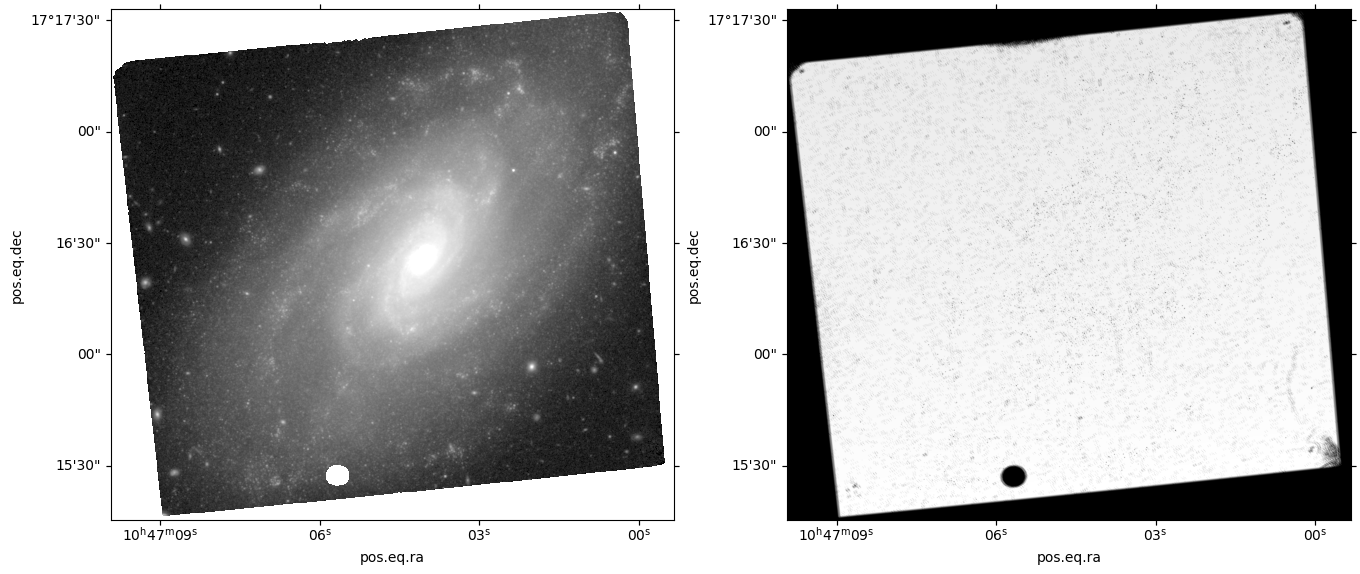

In [6]:
with fits.open('f160w_noopt_drz.fits') as hdu:
    im1wcs = wcs.WCS(hdu[1].header)
    sci1 = hdu[1].data
    wht1 = hdu[2].data
        
norm1 = ImageNormalize(sci1, vmin=-0.2, vmax=25, stretch=LogStretch())
fig, ax = plt.subplots(1, 2, figsize=(16, 8), subplot_kw={'projection':im1wcs})
ax[0].imshow(sci1, norm=norm1, cmap='gray', origin='lower')
ax[1].imshow(wht1, cmap='gray', origin='lower')

The drizzled science image is on the left and the associated weight image is on the right, both without optimization of the plate scale and pixfrac.

To compare, the figure plotted below shows close ups of the same part of the sky from the two drizzled products. 

(1835.4481178797876, 1934.1019662353688)

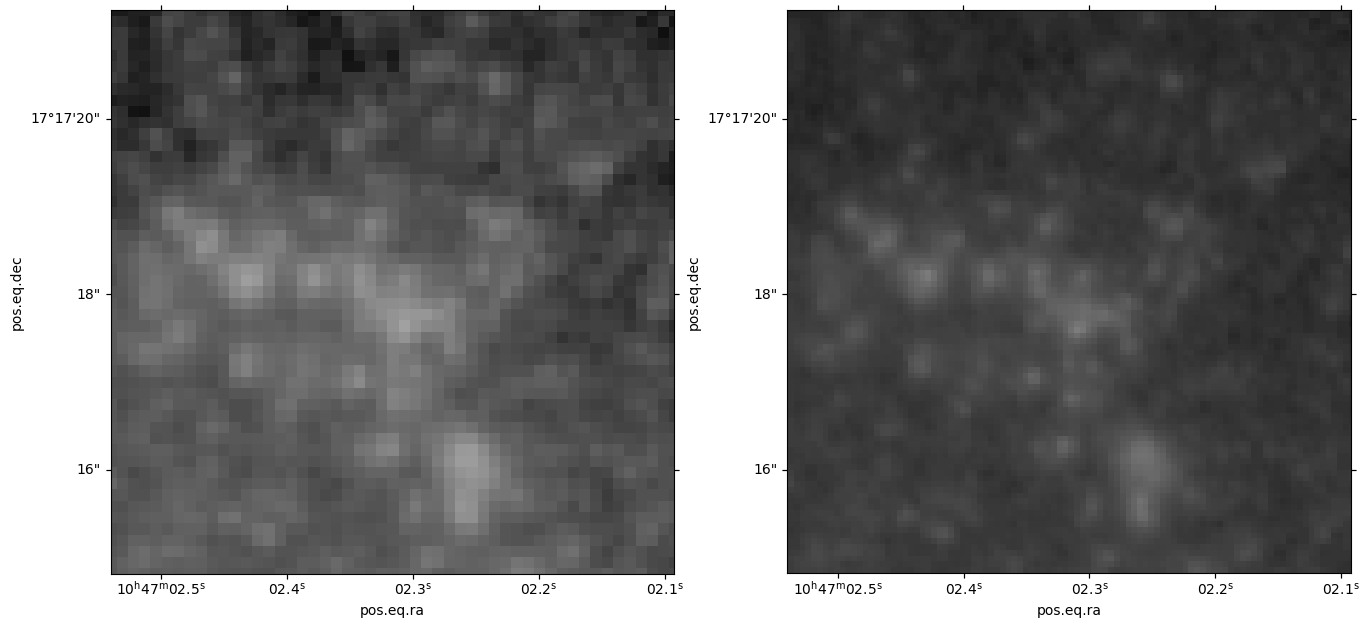

In [7]:
radeclims = wcs.utils.pixel_to_skycoord([825, 875], [930, 980], im1wcs)

with fits.open('f160w_opt_drz.fits') as hdu:
    im2wcs = wcs.WCS(hdu[1].header)
    sci2 = hdu[1].data
    wht2 = hdu[2].data

norm2 = ImageNormalize(sci2, vmin=-0.05, vmax=25, stretch=LogStretch())
    
fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(1, 2, 1, projection=im1wcs)
ax.imshow(sci1, norm=norm2, cmap='gray')
ax.set_xlim(radeclims.to_pixel(im1wcs)[0])
ax.set_ylim(radeclims.to_pixel(im1wcs)[1])

ax = fig.add_subplot(1, 2, 2, projection=im2wcs)
ax.imshow(sci2, norm=norm2, cmap='gray')
ax.set_xlim(radeclims.to_pixel(im2wcs)[0])
ax.set_ylim(radeclims.to_pixel(im2wcs)[1])                  

The image on the left is without improved plate scale and pixfrac, and shows that the detector undersamples the PSF. The image on the right is the image with improved parameters where the resolution is greatly improved. 

## 5. Optimizing the `final_pixfrac` parameter

While the optimized `final_pixfrac` in the example above was chosen from experience with using a four-point dither, the value that should be used is not known *a priori*. The value could be different depending on several factors. For example, if the number of images is greater than four, the value used for `final_pixfrac` could be smaller since more images are available to fill in holes in the output grid. On the other hand, it is possible that no dithering was used during the observations. In that case, `final_pixfrac` should be left at 1.0, since shrinking the size of the drop could be detrimental. 

Below, a series of experiments will be run to determine the best `final_pixfrac` value for the selected output plate scale, by varying pixfrac in steps of 0.1 over a range of values from 0.1 to 1.0.

In [8]:
pixfracs = np.arange(0.1, 1.1, 0.1)

for pixfrac in pixfracs:
    outname = 'f160w_{:.1f}'.format(pixfrac)
    drizzlepac.astrodrizzle.AstroDrizzle('*flt.fits',
                                         output=outname,
                                         runfile='',
                                         context=False,
                                         build=True,
                                         preserve=False,
                                         clean=True,
                                         driz_sep_bits='64,512',
                                         final_bits='64,512',
                                         final_pixfrac=pixfrac,
                                         final_wcs=True,
                                         final_rot=0.,
                                         final_scale=0.065)

No trailer file created...
AstroDrizzle log file: final.tra
AstroDrizzle Version 3.5.1 started at: 16:51:26.661 (19/04/2024)

==== Processing Step  Initialization  started at  16:51:26.661 (19/04/2024)



##############################################################################
#                                                                            #
# “minmed” is highly recommended for three images,                           #
#  and is good for four to six images,                                       #
#  but should be avoided for ten or more images.                             #
#                                                                            #
##############################################################################


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 1167.3829659085666  1056.5471233856526  
CD1_1 CD1_2  : -1.8055555555555558e-05  -1.5854340902423206e-23  
CD2_1 CD2_2  : -5.2878726791243137e-23  1.8055555555555558e-05  
NAXIS : 2336  2115
********************************************************************************
*
*  Estimated memory usage:  up to 257 Mb.
*  Output image size:       2336 X 2115 pixels. 
*  Output image file:       ~ 56 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step Initialization finished at 16:51:27.68 (19/04/2024)


==== Processing Step  Static Mask  started at  16:51:27.68 (19/04/2024)



==== Processing Step Static Mask finished at 16:51:27.801 (19/04/2024)


==== Processing Step  Subtract Sky  started at  16:51:27.802 (19/04/2024)



***** skymatch started on 2024-04-19 16:51:27.902604
      Version 1.0.9

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l6_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l7_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l9_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits'


       EXT = 'SCI',1
             Data units type: COUNT-RATE
             Conversion factor (data->brightness):  60.797431635711504




-----  Computing sky values requested image extensions (detector chips):  -----

   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits['SCI',1]'  --  SKY = 56.203832965924214 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.924444   NEW MDRIZSKY = 0.924444
   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits['SCI',1]'  --  SKY = 52.8972627889636 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.870058   NEW MDRIZSKY = 0.870058
   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits['SCI',1]'  --  SKY = 51.619641705121005 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.849043   NEW MDRIZSKY = 0.849043
   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits['SCI',1]'  --  SKY = 51.32938907415446 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.844269   NEW MDRIZSKY = 0.844269


   *   Image:   'ib1f19l6q_flt.fits['SCI',1]'  --  SKY = 56.203832965924214 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.924444   NEW MDRIZSKY = 0.924444
   *   Image:   'ib1f19l7q_flt.fits['SCI',1]'  --  SKY = 52.8972627889636 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.870058   NEW MDRIZSKY = 0.870058
   *   Image:   'ib1f19l9q_flt.fits['SCI',1]'  --  SKY = 51.619641705121005 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.849043   NEW MDRIZSKY = 0.849043
   *   Image:   'ib1f19laq_flt.fits['SCI',1]'  --  SKY = 51.32938907415446 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.844269   NEW MDRIZSKY = 0.844269
***** skymatch ended on 2024-04-19 16:51:28.205107
TOTAL RUN TIME: 0:00:00.302503


==== Processing Step Subtract Sky finished at 16:51:28.304 (19/04/2024)


==== Processing Step  Separate Drizzle  started at  16:51:28.304 (19/04/2024)



WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 544.5  481.5  
CD1_1 CD1_2  : -3.542984305540133e-05  3.723829036629122e-06  
CD2_1 CD2_2  : 3.723829036629122e-06  3.542984305540133e-05  
NAXIS : 1089  963


-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19la_single_sci.fits

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Writing out image to disk:

Deleted all instances of WCS with key C in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_sci.fits

Writing out image to disk:

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_sci.fits

hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_sci.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19la_single_sci.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_wht.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_wht.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_wht.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19la_single_wht.fits

-Generating simple FITS output: ib1f19l6q_single_sci.fits

-Generating simple FITS output: ib1f19l7q_single_sci.fits

-Generating simple FITS output: ib1f19laq_single_sci.fits

-Generating simple FITS output: ib1f19l9q_single_sci.fits

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Writing out image to disk:

ib1f19l7q_single_sci.fits

Writing out image to disk:

ib1f19l6q_single_sci.fits

Writing out image to disk:

Writing out image to disk:

ib1f19l9q_single_sci.fits

ib1f19laq_single_sci.fits

Writing out image to disk:

ib1f19l7q_single_wht.fits

Writing out image to disk:

Writing out image to disk:

ib1f19l6q_single_wht.fits

Writing out image to disk:

ib1f19l9q_single_wht.fits

ib1f19laq_single_wht.fits

==== Processing Step Separate Drizzle finished at 16:51:30.35 (19/04/2024)


==== Processing Step  Create Median  started at  16:51:30.359 (19/04/2024)



reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits' is 464.93669456453324
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits' is 437.5836524801294
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits' is 427.0147483274913
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits' is 424.6136825690036
reference sky value for image 'ib1f19l6q_flt.fits' is 464.93669456453324
reference sky value for image 'ib1f19l7q_flt.fits' is 437.5836524801294
reference sky value for image 'ib1f19l9q_flt.fits' is 427.0147483274913
reference sky value for image 'ib1f19laq_flt.fits' is 424.6136825690036


Saving output median image to: 'f160w_0.1_med.fits'
==== Processing Step Create Median finished at 16:51:30.787 (19/04/2024)


==== Processing Step  Blot  started at  16:51:30.787 (19/04/2024)



    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_blt.fits
    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits[sci,1]


Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_blt.fits
    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_blt.fits
    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l6q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19l6q_sci1_blt.fits
Writing out image to disk: ib1f19l6q_sci1_blt.fits


    Blot: creating blotted image:  ib1f19l7q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19l7q_sci1_blt.fits
Writing out image to disk: ib1f19l7q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l9q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l9q_sci1_blt.fits
Writing out image to disk: ib1f19l9q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19laq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19laq_sci1_blt.fits
Writing out image to disk: ib1f19laq_sci1_blt.fits


==== Processing Step Blot finished at 16:51:32.44 (19/04/2024)


==== Processing Step  Driz_CR  started at  16:51:32.442 (19/04/2024)



Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_crmask.fits

Creating output: ib1f19l7q_sci1_crmask.fits

Creating output: ib1f19l6q_sci1_crmask.fits

Creating output: ib1f19l9q_sci1_crmask.fits

Creating output: ib1f19laq_sci1_crmask.fits

==== Processing Step Driz_CR finished at 16:51:34.700 (19/04/2024)


==== Processing Step  Final Drizzle  started at  16:51:34.713 (19/04/2024)



WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 1167.3829659085666  1056.5471233856526  
CD1_1 CD1_2  : -1.8055555555555558e-05  -1.5854340902423206e-23  
CD2_1 CD2_2  : -5.2878726791243137e-23  1.8055555555555558e-05  
NAXIS : 2336  2115


-Generating multi-extension output file:  f160w_0.1_drz.fits
Deleted all instances of WCS with key A in extensions [1]
Deleted all instances of WCS with key B in extensions [1]
Deleted all instances of WCS with key C in extensions [1]
Writing out to disk: f160w_0.1_drz.fits
==== Processing Step Final Drizzle finished at 16:51:37.074 (19/04/2024)



AstroDrizzle Version 3.5.1 is finished processing at 16:51:37.075 (19/04/2024).





   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.0216 sec.
            Static Mask          0.1174 sec.
           Subtract Sky          0.5023 sec.
       Separate Drizzle          2.0537 sec.
          Create Median          0.4275 sec.
                   Blot          1.6544 sec.
                Driz_CR          2.2583 sec.
          Final Drizzle          2.3615 sec.
   ====================          ====================
                  Total          10.3967 sec.



No trailer file saved...
No trailer file created...
AstroDrizzle log file: final.tra
AstroDrizzle Version 3.5.1 started at: 16:51:37.123 (19/04/2024)

==== Processing Step  Initialization  started at  16:51:37.123 (19/04/2024)



##############################################################################
#                                                                            #
# “minmed” is highly recommended for three images,                           #
#  and is good for four to six images,                                       #
#  but should be avoided for ten or more images.                             #
#                                                                            #
##############################################################################


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 1167.3829659085666  1056.5471233856526  
CD1_1 CD1_2  : -1.8055555555555558e-05  -1.5854340902423206e-23  
CD2_1 CD2_2  : -5.2878726791243137e-23  1.8055555555555558e-05  
NAXIS : 2336  2115
********************************************************************************
*
*  Estimated memory usage:  up to 257 Mb.
*  Output image size:       2336 X 2115 pixels. 
*  Output image file:       ~ 56 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step Initialization finished at 16:51:38.268 (19/04/2024)


==== Processing Step  Static Mask  started at  16:51:38.268 (19/04/2024)



==== Processing Step Static Mask finished at 16:51:38.388 (19/04/2024)


==== Processing Step  Subtract Sky  started at  16:51:38.388 (19/04/2024)



***** skymatch started on 2024-04-19 16:51:38.489263
      Version 1.0.9

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l6_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l7_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l9_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits'


       EXT = 'SCI',1
             Data units type: COUNT-RATE
             Conversion factor (data->brightness):  60.797431635711504


-----  Computing sky values requested image extensions (detector chips):  -----



   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits['SCI',1]'  --  SKY = 56.203832965924214 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.924444   NEW MDRIZSKY = 0.924444
   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits['SCI',1]'  --  SKY = 52.8972627889636 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.870058   NEW MDRIZSKY = 0.870058
   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits['SCI',1]'  --  SKY = 51.619641705121005 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.849043   NEW MDRIZSKY = 0.849043
   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits['SCI',1]'  --  SKY = 51.32938907415446 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.844269   NEW MDRIZSKY = 0.844269


   *   Image:   'ib1f19l6q_flt.fits['SCI',1]'  --  SKY = 56.203832965924214 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.924444   NEW MDRIZSKY = 0.924444
   *   Image:   'ib1f19l7q_flt.fits['SCI',1]'  --  SKY = 52.8972627889636 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.870058   NEW MDRIZSKY = 0.870058
   *   Image:   'ib1f19l9q_flt.fits['SCI',1]'  --  SKY = 51.619641705121005 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.849043   NEW MDRIZSKY = 0.849043
   *   Image:   'ib1f19laq_flt.fits['SCI',1]'  --  SKY = 51.32938907415446 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.844269   NEW MDRIZSKY = 0.844269
***** skymatch ended on 2024-04-19 16:51:38.794003
TOTAL RUN TIME: 0:00:00.304740


==== Processing Step Subtract Sky finished at 16:51:38.895 (19/04/2024)


==== Processing Step  Separate Drizzle  started at  16:51:38.895 (19/04/2024)



WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 544.5  481.5  
CD1_1 CD1_2  : -3.542984305540133e-05  3.723829036629122e-06  
CD2_1 CD2_2  : 3.723829036629122e-06  3.542984305540133e-05  
NAXIS : 1089  963


-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19la_single_sci.fits

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_sci.fits

Deleted all instances of WCS with key C in extensions [0]

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19la_single_sci.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_sci.fits

Writing out image to disk:

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_sci.fits

hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_wht.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19la_single_wht.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_wht.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_wht.fits

-Generating simple FITS output: ib1f19l6q_single_sci.fits

-Generating simple FITS output: ib1f19l7q_single_sci.fits

-Generating simple FITS output: ib1f19l9q_single_sci.fits

-Generating simple FITS output: ib1f19laq_single_sci.fits

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Writing out image to disk:

ib1f19l6q_single_sci.fits

Deleted all instances of WCS with key B in extensions [0]

Writing out image to disk:

Writing out image to disk:

ib1f19l9q_single_sci.fits

ib1f19l7q_single_sci.fits

Writing out image to disk:

ib1f19laq_single_sci.fits

Writing out image to disk:

ib1f19l6q_single_wht.fits

Writing out image to disk:

ib1f19l9q_single_wht.fits

Writing out image to disk:

ib1f19l7q_single_wht.fits

Writing out image to disk:

ib1f19laq_single_wht.fits

==== Processing Step Separate Drizzle finished at 16:51:40.951 (19/04/2024)


==== Processing Step  Create Median  started at  16:51:40.952 (19/04/2024)



reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits' is 464.93669456453324
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits' is 437.5836524801294
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits' is 427.0147483274913
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits' is 424.6136825690036
reference sky value for image 'ib1f19l6q_flt.fits' is 464.93669456453324
reference sky value for image 'ib1f19l7q_flt.fits' is 437.5836524801294
reference sky value for image 'ib1f19l9q_flt.fits' is 427.0147483274913
reference sky value for image 'ib1f19laq_flt.fits' is 424.6136825690036


Saving output median image to: 'f160w_0.2_med.fits'
==== Processing Step Create Median finished at 16:51:41.376 (19/04/2024)


==== Processing Step  Blot  started at  16:51:41.377 (19/04/2024)



    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_blt.fits


    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits[sci,1]


Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_blt.fits
    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_blt.fits
    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_blt.fits


    Blot: creating blotted image:  ib1f19l6q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19l6q_sci1_blt.fits
Writing out image to disk: ib1f19l6q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l7q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l7q_sci1_blt.fits
Writing out image to disk: ib1f19l7q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l9q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19l9q_sci1_blt.fits
Writing out image to disk: ib1f19l9q_sci1_blt.fits


    Blot: creating blotted image:  ib1f19laq_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19laq_sci1_blt.fits
Writing out image to disk: ib1f19laq_sci1_blt.fits
==== Processing Step Blot finished at 16:51:43.019 (19/04/2024)


==== Processing Step  Driz_CR  started at  16:51:43.020 (19/04/2024)



Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_crmask.fits

Creating output: ib1f19l6q_sci1_crmask.fits

Creating output: ib1f19l7q_sci1_crmask.fits

Creating output: ib1f19laq_sci1_crmask.fits

Creating output: ib1f19l9q_sci1_crmask.fits

==== Processing Step Driz_CR finished at 16:51:45.277 (19/04/2024)


==== Processing Step  Final Drizzle  started at  16:51:45.288 (19/04/2024)



WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 1167.3829659085666  1056.5471233856526  
CD1_1 CD1_2  : -1.8055555555555558e-05  -1.5854340902423206e-23  
CD2_1 CD2_2  : -5.2878726791243137e-23  1.8055555555555558e-05  
NAXIS : 2336  2115


-Generating multi-extension output file:  f160w_0.2_drz.fits
Deleted all instances of WCS with key A in extensions [1]
Deleted all instances of WCS with key B in extensions [1]
Deleted all instances of WCS with key C in extensions [1]
Writing out to disk: f160w_0.2_drz.fits
==== Processing Step Final Drizzle finished at 16:51:47.752 (19/04/2024)



AstroDrizzle Version 3.5.1 is finished processing at 16:51:47.753 (19/04/2024).





   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.1448 sec.
            Static Mask          0.1194 sec.
           Subtract Sky          0.5066 sec.
       Separate Drizzle          2.0557 sec.
          Create Median          0.4246 sec.
                   Blot          1.6424 sec.
                Driz_CR          2.2569 sec.
          Final Drizzle          2.4641 sec.
   ====================          ====================
                  Total          10.6146 sec.



No trailer file saved...
No trailer file created...
AstroDrizzle log file: final.tra
AstroDrizzle Version 3.5.1 started at: 16:51:47.80 (19/04/2024)

==== Processing Step  Initialization  started at  16:51:47.801 (19/04/2024)



##############################################################################
#                                                                            #
# “minmed” is highly recommended for three images,                           #
#  and is good for four to six images,                                       #
#  but should be avoided for ten or more images.                             #
#                                                                            #
##############################################################################


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 1167.3829659085666  1056.5471233856526  
CD1_1 CD1_2  : -1.8055555555555558e-05  -1.5854340902423206e-23  
CD2_1 CD2_2  : -5.2878726791243137e-23  1.8055555555555558e-05  
NAXIS : 2336  2115
********************************************************************************
*
*  Estimated memory usage:  up to 257 Mb.
*  Output image size:       2336 X 2115 pixels. 
*  Output image file:       ~ 56 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step Initialization finished at 16:51:48.964 (19/04/2024)


==== Processing Step  Static Mask  started at  16:51:48.964 (19/04/2024)



==== Processing Step Static Mask finished at 16:51:49.084 (19/04/2024)


==== Processing Step  Subtract Sky  started at  16:51:49.08 (19/04/2024)



***** skymatch started on 2024-04-19 16:51:49.184666
      Version 1.0.9

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l6_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l7_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l9_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits'


       EXT = 'SCI',1
             Data units type: COUNT-RATE
             Conversion factor (data->brightness):  60.797431635711504




-----  Computing sky values requested image extensions (detector chips):  -----

   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits['SCI',1]'  --  SKY = 56.203832965924214 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.924444   NEW MDRIZSKY = 0.924444
   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits['SCI',1]'  --  SKY = 52.8972627889636 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.870058   NEW MDRIZSKY = 0.870058
   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits['SCI',1]'  --  SKY = 51.619641705121005 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.849043   NEW MDRIZSKY = 0.849043


   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits['SCI',1]'  --  SKY = 51.32938907415446 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.844269   NEW MDRIZSKY = 0.844269
   *   Image:   'ib1f19l6q_flt.fits['SCI',1]'  --  SKY = 56.203832965924214 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.924444   NEW MDRIZSKY = 0.924444
   *   Image:   'ib1f19l7q_flt.fits['SCI',1]'  --  SKY = 52.8972627889636 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.870058   NEW MDRIZSKY = 0.870058
   *   Image:   'ib1f19l9q_flt.fits['SCI',1]'  --  SKY = 51.619641705121005 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.849043   NEW MDRIZSKY = 0.849043


   *   Image:   'ib1f19laq_flt.fits['SCI',1]'  --  SKY = 51.32938907415446 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.844269   NEW MDRIZSKY = 0.844269
***** skymatch ended on 2024-04-19 16:51:49.492641
TOTAL RUN TIME: 0:00:00.307975


==== Processing Step Subtract Sky finished at 16:51:49.596 (19/04/2024)


==== Processing Step  Separate Drizzle  started at  16:51:49.597 (19/04/2024)



WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 544.5  481.5  
CD1_1 CD1_2  : -3.542984305540133e-05  3.723829036629122e-06  
CD2_1 CD2_2  : 3.723829036629122e-06  3.542984305540133e-05  
NAXIS : 1089  963


-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19la_single_sci.fits

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_sci.fits

Writing out image to disk:

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_sci.fits

hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_sci.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19la_single_sci.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_wht.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_wht.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_wht.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19la_single_wht.fits

-Generating simple FITS output: ib1f19l6q_single_sci.fits

-Generating simple FITS output: ib1f19l7q_single_sci.fits

-Generating simple FITS output: ib1f19l9q_single_sci.fits

-Generating simple FITS output: ib1f19laq_single_sci.fits

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Writing out image to disk:

Deleted all instances of WCS with key B in extensions [0]

ib1f19l6q_single_sci.fits

Writing out image to disk:

ib1f19l7q_single_sci.fits

Writing out image to disk:

Writing out image to disk:

ib1f19l9q_single_sci.fits

ib1f19laq_single_sci.fits

Writing out image to disk:

ib1f19l6q_single_wht.fits

Writing out image to disk:

ib1f19l7q_single_wht.fits

Writing out image to disk:

ib1f19l9q_single_wht.fits

Writing out image to disk:

ib1f19laq_single_wht.fits

==== Processing Step Separate Drizzle finished at 16:51:51.656 (19/04/2024)


==== Processing Step  Create Median  started at  16:51:51.657 (19/04/2024)



reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits' is 464.93669456453324
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits' is 437.5836524801294
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits' is 427.0147483274913
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits' is 424.6136825690036
reference sky value for image 'ib1f19l6q_flt.fits' is 464.93669456453324
reference sky value for image 'ib1f19l7q_flt.fits' is 437.5836524801294
reference sky value for image 'ib1f19l9q_flt.fits' is 427.0147483274913
reference sky value for image 'ib1f19laq_flt.fits' is 424.6136825690036


Saving output median image to: 'f160w_0.3_med.fits'
==== Processing Step Create Median finished at 16:51:52.083 (19/04/2024)


==== Processing Step  Blot  started at  16:51:52.083 (19/04/2024)



    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_blt.fits
    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits[sci,1]


Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_blt.fits
    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_blt.fits
    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_blt.fits


    Blot: creating blotted image:  ib1f19l6q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19l6q_sci1_blt.fits
Writing out image to disk: ib1f19l6q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l7q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l7q_sci1_blt.fits
Writing out image to disk: ib1f19l7q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l9q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19l9q_sci1_blt.fits
Writing out image to disk: ib1f19l9q_sci1_blt.fits


    Blot: creating blotted image:  ib1f19laq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19laq_sci1_blt.fits
Writing out image to disk: ib1f19laq_sci1_blt.fits
==== Processing Step Blot finished at 16:51:53.627 (19/04/2024)


==== Processing Step  Driz_CR  started at  16:51:53.627 (19/04/2024)



Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_crmask.fits

Creating output: ib1f19l6q_sci1_crmask.fits

Creating output: ib1f19l7q_sci1_crmask.fits

Creating output: ib1f19l9q_sci1_crmask.fits

Creating output: ib1f19laq_sci1_crmask.fits

==== Processing Step Driz_CR finished at 16:51:55.849 (19/04/2024)


==== Processing Step  Final Drizzle  started at  16:51:55.862 (19/04/2024)



WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 1167.3829659085666  1056.5471233856526  
CD1_1 CD1_2  : -1.8055555555555558e-05  -1.5854340902423206e-23  
CD2_1 CD2_2  : -5.2878726791243137e-23  1.8055555555555558e-05  
NAXIS : 2336  2115


-Generating multi-extension output file:  f160w_0.3_drz.fits
Deleted all instances of WCS with key A in extensions [1]
Deleted all instances of WCS with key B in extensions [1]
Deleted all instances of WCS with key C in extensions [1]
Writing out to disk: f160w_0.3_drz.fits
==== Processing Step Final Drizzle finished at 16:51:58.617 (19/04/2024)



AstroDrizzle Version 3.5.1 is finished processing at 16:51:58.618 (19/04/2024).





   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.1628 sec.
            Static Mask          0.1195 sec.
           Subtract Sky          0.5122 sec.
       Separate Drizzle          2.0592 sec.
          Create Median          0.4256 sec.
                   Blot          1.5437 sec.
                Driz_CR          2.2222 sec.
          Final Drizzle          2.7553 sec.
   ====================          ====================
                  Total          10.8006 sec.



No trailer file saved...
No trailer file created...
AstroDrizzle log file: final.tra
AstroDrizzle Version 3.5.1 started at: 16:51:58.664 (19/04/2024)

==== Processing Step  Initialization  started at  16:51:58.665 (19/04/2024)



##############################################################################
#                                                                            #
# “minmed” is highly recommended for three images,                           #
#  and is good for four to six images,                                       #
#  but should be avoided for ten or more images.                             #
#                                                                            #
##############################################################################


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 1167.3829659085666  1056.5471233856526  
CD1_1 CD1_2  : -1.8055555555555558e-05  -1.5854340902423206e-23  
CD2_1 CD2_2  : -5.2878726791243137e-23  1.8055555555555558e-05  
NAXIS : 2336  2115
********************************************************************************
*
*  Estimated memory usage:  up to 257 Mb.
*  Output image size:       2336 X 2115 pixels. 
*  Output image file:       ~ 56 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step Initialization finished at 16:51:59.721 (19/04/2024)


==== Processing Step  Static Mask  started at  16:51:59.722 (19/04/2024)



==== Processing Step Static Mask finished at 16:51:59.841 (19/04/2024)


==== Processing Step  Subtract Sky  started at  16:51:59.842 (19/04/2024)



***** skymatch started on 2024-04-19 16:52:00.049823
      Version 1.0.9

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l6_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l7_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l9_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits'


   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits['SCI',1]'  --  SKY = 51.32938907415446 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.844269   NEW MDRIZSKY = 0.844269
   *   Image:   'ib1f19l6q_flt.fits['SCI',1]'  --  SKY = 56.203832965924214 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.924444   NEW MDRIZSKY = 0.924444
   *   Image:   'ib1f19l7q_flt.fits['SCI',1]'  --  SKY = 52.8972627889636 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.870058   NEW MDRIZSKY = 0.870058
   *   Image:   'ib1f19l9q_flt.fits['SCI',1]'  --  SKY = 51.619641705121005 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.849043   NEW MDRIZSKY = 0.849043
   *   Image:   'ib1f19laq_flt.fits['SCI',1]'  --  SKY = 51.32938907415446 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZ

==== Processing Step  Separate Drizzle  started at  16:52:00.460 (19/04/2024)



WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 544.5  481.5  
CD1_1 CD1_2  : -3.542984305540133e-05  3.723829036629122e-06  
CD2_1 CD2_2  : 3.723829036629122e-06  3.542984305540133e-05  
NAXIS : 1089  963


-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19la_single_sci.fits

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_sci.fits

Writing out image to disk:

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_sci.fits

Deleted all instances of WCS with key C in extensions [0]

hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_sci.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19la_single_sci.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_wht.fits

Writing out image to disk:

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_wht.fits

hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_wht.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19la_single_wht.fits

-Generating simple FITS output: ib1f19l6q_single_sci.fits

-Generating simple FITS output: ib1f19l7q_single_sci.fits

-Generating simple FITS output: ib1f19l9q_single_sci.fits

-Generating simple FITS output: ib1f19laq_single_sci.fits

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Writing out image to disk:

Writing out image to disk:

ib1f19l6q_single_sci.fits

ib1f19l7q_single_sci.fits

Deleted all instances of WCS with key B in extensions [0]

Writing out image to disk:

ib1f19l9q_single_sci.fits

Writing out image to disk:

ib1f19laq_single_sci.fits

Writing out image to disk:

ib1f19l6q_single_wht.fits

Writing out image to disk:

ib1f19l7q_single_wht.fits

Writing out image to disk:

Writing out image to disk:

ib1f19l9q_single_wht.fits

ib1f19laq_single_wht.fits

==== Processing Step Separate Drizzle finished at 16:52:02.519 (19/04/2024)


==== Processing Step  Create Median  started at  16:52:02.52 (19/04/2024)



reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits' is 464.93669456453324
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits' is 437.5836524801294
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits' is 427.0147483274913
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits' is 424.6136825690036
reference sky value for image 'ib1f19l6q_flt.fits' is 464.93669456453324
reference sky value for image 'ib1f19l7q_flt.fits' is 437.5836524801294
reference sky value for image 'ib1f19l9q_flt.fits' is 427.0147483274913
reference sky value for image 'ib1f19laq_flt.fits' is 424.6136825690036


Saving output median image to: 'f160w_0.4_med.fits'
==== Processing Step Create Median finished at 16:52:02.947 (19/04/2024)


==== Processing Step  Blot  started at  16:52:02.947 (19/04/2024)



    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_blt.fits


    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits[sci,1]


Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_blt.fits
    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_blt.fits
    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_blt.fits


    Blot: creating blotted image:  ib1f19l6q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19l6q_sci1_blt.fits
Writing out image to disk: ib1f19l6q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l7q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l7q_sci1_blt.fits
Writing out image to disk: ib1f19l7q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l9q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19l9q_sci1_blt.fits
Writing out image to disk: ib1f19l9q_sci1_blt.fits


    Blot: creating blotted image:  ib1f19laq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19laq_sci1_blt.fits
Writing out image to disk: ib1f19laq_sci1_blt.fits
==== Processing Step Blot finished at 16:52:04.490 (19/04/2024)


==== Processing Step  Driz_CR  started at  16:52:04.491 (19/04/2024)



Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_crmask.fits

Creating output: ib1f19l6q_sci1_crmask.fits

Creating output: ib1f19l7q_sci1_crmask.fits

Creating output: ib1f19l9q_sci1_crmask.fits

Creating output: ib1f19laq_sci1_crmask.fits

==== Processing Step Driz_CR finished at 16:52:06.752 (19/04/2024)


==== Processing Step  Final Drizzle  started at  16:52:06.764 (19/04/2024)



WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 1167.3829659085666  1056.5471233856526  
CD1_1 CD1_2  : -1.8055555555555558e-05  -1.5854340902423206e-23  
CD2_1 CD2_2  : -5.2878726791243137e-23  1.8055555555555558e-05  
NAXIS : 2336  2115


-Generating multi-extension output file:  f160w_0.4_drz.fits
Deleted all instances of WCS with key A in extensions [1]
Deleted all instances of WCS with key B in extensions [1]
Deleted all instances of WCS with key C in extensions [1]
Writing out to disk: f160w_0.4_drz.fits
==== Processing Step Final Drizzle finished at 16:52:09.679 (19/04/2024)



AstroDrizzle Version 3.5.1 is finished processing at 16:52:09.679 (19/04/2024).





   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.0568 sec.
            Static Mask          0.1194 sec.
           Subtract Sky          0.6179 sec.
       Separate Drizzle          2.0592 sec.
          Create Median          0.4264 sec.
                   Blot          1.5434 sec.
                Driz_CR          2.2615 sec.
          Final Drizzle          2.9144 sec.
   ====================          ====================
                  Total          10.9990 sec.



No trailer file saved...
No trailer file created...
AstroDrizzle log file: final.tra
AstroDrizzle Version 3.5.1 started at: 16:52:09.725 (19/04/2024)

==== Processing Step  Initialization  started at  16:52:09.725 (19/04/2024)



##############################################################################
#                                                                            #
# “minmed” is highly recommended for three images,                           #
#  and is good for four to six images,                                       #
#  but should be avoided for ten or more images.                             #
#                                                                            #
##############################################################################


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 1167.3829659085666  1056.5471233856526  
CD1_1 CD1_2  : -1.8055555555555558e-05  -1.5854340902423206e-23  
CD2_1 CD2_2  : -5.2878726791243137e-23  1.8055555555555558e-05  
NAXIS : 2336  2115
********************************************************************************
*
*  Estimated memory usage:  up to 257 Mb.
*  Output image size:       2336 X 2115 pixels. 
*  Output image file:       ~ 56 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step Initialization finished at 16:52:10.769 (19/04/2024)


==== Processing Step  Static Mask  started at  16:52:10.770 (19/04/2024)



==== Processing Step Static Mask finished at 16:52:10.888 (19/04/2024)


==== Processing Step  Subtract Sky  started at  16:52:10.889 (19/04/2024)



***** skymatch started on 2024-04-19 16:52:10.989919
      Version 1.0.9

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l6_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l7_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l9_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits'


       EXT = 'SCI',1
             Data units type: COUNT-RATE
             Conversion factor (data->brightness):  60.797431635711504


-----  Computing sky values requested image extensions (detector chips):  -----

   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits['SCI',1]'  --  SKY = 56.203832965924214 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.924444   NEW MDRIZSKY = 0.924444
   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits['SCI',1]'  --  SKY = 52.8972627889636 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.870058   NEW MDRIZSKY = 0.870058
   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits['SCI',1]'  --  SKY = 51.619641705121005 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.849043   NEW MDRIZSKY = 0.849043


   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits['SCI',1]'  --  SKY = 51.32938907415446 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.844269   NEW MDRIZSKY = 0.844269
   *   Image:   'ib1f19l6q_flt.fits['SCI',1]'  --  SKY = 56.203832965924214 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.924444   NEW MDRIZSKY = 0.924444
   *   Image:   'ib1f19l7q_flt.fits['SCI',1]'  --  SKY = 52.8972627889636 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.870058   NEW MDRIZSKY = 0.870058
   *   Image:   'ib1f19l9q_flt.fits['SCI',1]'  --  SKY = 51.619641705121005 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.849043   NEW MDRIZSKY = 0.849043
   *   Image:   'ib1f19laq_flt.fits['SCI',1]'  --  SKY = 51.32938907415446 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZ

==== Processing Step Subtract Sky finished at 16:52:11.404 (19/04/2024)


==== Processing Step  Separate Drizzle  started at  16:52:11.404 (19/04/2024)



WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 544.5  481.5  
CD1_1 CD1_2  : -3.542984305540133e-05  3.723829036629122e-06  
CD2_1 CD2_2  : 3.723829036629122e-06  3.542984305540133e-05  
NAXIS : 1089  963


-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19la_single_sci.fits

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_sci.fits

Writing out image to disk:

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_sci.fits

hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_sci.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19la_single_sci.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_wht.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_wht.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_wht.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19la_single_wht.fits

-Generating simple FITS output: ib1f19l6q_single_sci.fits

-Generating simple FITS output: ib1f19l7q_single_sci.fits

-Generating simple FITS output: ib1f19laq_single_sci.fits

-Generating simple FITS output: ib1f19l9q_single_sci.fits

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Writing out image to disk:

ib1f19l6q_single_sci.fits

Writing out image to disk:

Writing out image to disk:

ib1f19l7q_single_sci.fits

ib1f19laq_single_sci.fits

Writing out image to disk:

ib1f19l9q_single_sci.fits

Writing out image to disk:

ib1f19l6q_single_wht.fits

Writing out image to disk:

ib1f19laq_single_wht.fits

Writing out image to disk:

Writing out image to disk:

ib1f19l7q_single_wht.fits

ib1f19l9q_single_wht.fits

==== Processing Step Separate Drizzle finished at 16:52:13.457 (19/04/2024)


==== Processing Step  Create Median  started at  16:52:13.458 (19/04/2024)



reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits' is 464.93669456453324
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits' is 437.5836524801294
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits' is 427.0147483274913
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits' is 424.6136825690036
reference sky value for image 'ib1f19l6q_flt.fits' is 464.93669456453324
reference sky value for image 'ib1f19l7q_flt.fits' is 437.5836524801294
reference sky value for image 'ib1f19l9q_flt.fits' is 427.0147483274913
reference sky value for image 'ib1f19laq_flt.fits' is 424.6136825690036


Saving output median image to: 'f160w_0.5_med.fits'
==== Processing Step Create Median finished at 16:52:13.884 (19/04/2024)


==== Processing Step  Blot  started at  16:52:13.885 (19/04/2024)



    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_blt.fits
    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits[sci,1]


Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_blt.fits
    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_blt.fits
    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_blt.fits


Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l6q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19l6q_sci1_blt.fits
Writing out image to disk: ib1f19l6q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l7q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l7q_sci1_blt.fits
Writing out image to disk: ib1f19l7q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l9q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19l9q_sci1_blt.fits
Writing out image to disk: ib1f19l9q_sci1_blt.fits


    Blot: creating blotted image:  ib1f19laq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19laq_sci1_blt.fits
Writing out image to disk: ib1f19laq_sci1_blt.fits
==== Processing Step Blot finished at 16:52:15.526 (19/04/2024)


==== Processing Step  Driz_CR  started at  16:52:15.526 (19/04/2024)



Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_crmask.fits

Creating output: ib1f19l6q_sci1_crmask.fits

Creating output: ib1f19l7q_sci1_crmask.fits

Creating output: ib1f19l9q_sci1_crmask.fits

Creating output: ib1f19laq_sci1_crmask.fits

==== Processing Step Driz_CR finished at 16:52:17.771 (19/04/2024)


==== Processing Step  Final Drizzle  started at  16:52:17.784 (19/04/2024)



WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 1167.3829659085666  1056.5471233856526  
CD1_1 CD1_2  : -1.8055555555555558e-05  -1.5854340902423206e-23  
CD2_1 CD2_2  : -5.2878726791243137e-23  1.8055555555555558e-05  
NAXIS : 2336  2115


-Generating multi-extension output file:  f160w_0.5_drz.fits
Deleted all instances of WCS with key A in extensions [1]
Deleted all instances of WCS with key B in extensions [1]
Deleted all instances of WCS with key C in extensions [1]
Writing out to disk: f160w_0.5_drz.fits
==== Processing Step Final Drizzle finished at 16:52:20.704 (19/04/2024)



AstroDrizzle Version 3.5.1 is finished processing at 16:52:20.705 (19/04/2024).





   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.0436 sec.
            Static Mask          0.1188 sec.
           Subtract Sky          0.5147 sec.
       Separate Drizzle          2.0530 sec.
          Create Median          0.4259 sec.
                   Blot          1.6414 sec.
                Driz_CR          2.2450 sec.
          Final Drizzle          2.9205 sec.
   ====================          ====================
                  Total          10.9629 sec.



No trailer file saved...
No trailer file created...
AstroDrizzle log file: final.tra
AstroDrizzle Version 3.5.1 started at: 16:52:20.753 (19/04/2024)

==== Processing Step  Initialization  started at  16:52:20.753 (19/04/2024)



##############################################################################
#                                                                            #
# “minmed” is highly recommended for three images,                           #
#  and is good for four to six images,                                       #
#  but should be avoided for ten or more images.                             #
#                                                                            #
##############################################################################


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 1167.3829659085666  1056.5471233856526  
CD1_1 CD1_2  : -1.8055555555555558e-05  -1.5854340902423206e-23  
CD2_1 CD2_2  : -5.2878726791243137e-23  1.8055555555555558e-05  
NAXIS : 2336  2115
********************************************************************************
*
*  Estimated memory usage:  up to 257 Mb.
*  Output image size:       2336 X 2115 pixels. 
*  Output image file:       ~ 56 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step Initialization finished at 16:52:21.916 (19/04/2024)


==== Processing Step  Static Mask  started at  16:52:21.916 (19/04/2024)



==== Processing Step Static Mask finished at 16:52:22.036 (19/04/2024)


==== Processing Step  Subtract Sky  started at  16:52:22.036 (19/04/2024)



***** skymatch started on 2024-04-19 16:52:22.136750
      Version 1.0.9

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l6_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l7_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l9_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits'


       EXT = 'SCI',1
             Data units type: COUNT-RATE
             Conversion factor (data->brightness):  60.797431635711504




-----  Computing sky values requested image extensions (detector chips):  -----

   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits['SCI',1]'  --  SKY = 56.203832965924214 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.924444   NEW MDRIZSKY = 0.924444
   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits['SCI',1]'  --  SKY = 52.8972627889636 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.870058   NEW MDRIZSKY = 0.870058
   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits['SCI',1]'  --  SKY = 51.619641705121005 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.849043   NEW MDRIZSKY = 0.849043


   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits['SCI',1]'  --  SKY = 51.32938907415446 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.844269   NEW MDRIZSKY = 0.844269
   *   Image:   'ib1f19l6q_flt.fits['SCI',1]'  --  SKY = 56.203832965924214 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.924444   NEW MDRIZSKY = 0.924444
   *   Image:   'ib1f19l7q_flt.fits['SCI',1]'  --  SKY = 52.8972627889636 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.870058   NEW MDRIZSKY = 0.870058
   *   Image:   'ib1f19l9q_flt.fits['SCI',1]'  --  SKY = 51.619641705121005 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.849043   NEW MDRIZSKY = 0.849043
   *   Image:   'ib1f19laq_flt.fits['SCI',1]'  --  SKY = 51.32938907415446 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZ

==== Processing Step Subtract Sky finished at 16:52:22.546 (19/04/2024)


==== Processing Step  Separate Drizzle  started at  16:52:22.546 (19/04/2024)



WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 544.5  481.5  
CD1_1 CD1_2  : -3.542984305540133e-05  3.723829036629122e-06  
CD2_1 CD2_2  : 3.723829036629122e-06  3.542984305540133e-05  
NAXIS : 1089  963


-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19la_single_sci.fits

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_sci.fits

Writing out image to disk:

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_sci.fits

hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_sci.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19la_single_sci.fits

Writing out image to disk:

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_wht.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_wht.fits

hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_wht.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19la_single_wht.fits

-Generating simple FITS output: ib1f19l6q_single_sci.fits

-Generating simple FITS output: ib1f19l7q_single_sci.fits

-Generating simple FITS output: ib1f19l9q_single_sci.fits

-Generating simple FITS output: ib1f19laq_single_sci.fits

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Writing out image to disk:

ib1f19l7q_single_sci.fits

Deleted all instances of WCS with key B in extensions [0]

Writing out image to disk:

Writing out image to disk:

ib1f19l6q_single_sci.fits

ib1f19l9q_single_sci.fits

Writing out image to disk:

ib1f19laq_single_sci.fits

Writing out image to disk:

ib1f19l7q_single_wht.fits

Writing out image to disk:

ib1f19l9q_single_wht.fits

Writing out image to disk:

ib1f19l6q_single_wht.fits

Writing out image to disk:

ib1f19laq_single_wht.fits

==== Processing Step Separate Drizzle finished at 16:52:24.601 (19/04/2024)


==== Processing Step  Create Median  started at  16:52:24.602 (19/04/2024)



reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits' is 464.93669456453324
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits' is 437.5836524801294
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits' is 427.0147483274913
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits' is 424.6136825690036
reference sky value for image 'ib1f19l6q_flt.fits' is 464.93669456453324
reference sky value for image 'ib1f19l7q_flt.fits' is 437.5836524801294
reference sky value for image 'ib1f19l9q_flt.fits' is 427.0147483274913
reference sky value for image 'ib1f19laq_flt.fits' is 424.6136825690036


Saving output median image to: 'f160w_0.6_med.fits'
==== Processing Step Create Median finished at 16:52:25.030 (19/04/2024)


==== Processing Step  Blot  started at  16:52:25.031 (19/04/2024)



    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_blt.fits
    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits[sci,1]


Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_blt.fits
    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_blt.fits
    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_blt.fits


    Blot: creating blotted image:  ib1f19l6q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19l6q_sci1_blt.fits
Writing out image to disk: ib1f19l6q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l7q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l7q_sci1_blt.fits
Writing out image to disk: ib1f19l7q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l9q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19l9q_sci1_blt.fits
Writing out image to disk: ib1f19l9q_sci1_blt.fits


    Blot: creating blotted image:  ib1f19laq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19laq_sci1_blt.fits
Writing out image to disk: ib1f19laq_sci1_blt.fits
==== Processing Step Blot finished at 16:52:26.687 (19/04/2024)


==== Processing Step  Driz_CR  started at  16:52:26.687 (19/04/2024)



Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_crmask.fits

Creating output: ib1f19l6q_sci1_crmask.fits

Creating output: ib1f19l7q_sci1_crmask.fits

Creating output: ib1f19l9q_sci1_crmask.fits

Creating output: ib1f19laq_sci1_crmask.fits

==== Processing Step Driz_CR finished at 16:52:28.942 (19/04/2024)


==== Processing Step  Final Drizzle  started at  16:52:28.95 (19/04/2024)



WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 1167.3829659085666  1056.5471233856526  
CD1_1 CD1_2  : -1.8055555555555558e-05  -1.5854340902423206e-23  
CD2_1 CD2_2  : -5.2878726791243137e-23  1.8055555555555558e-05  
NAXIS : 2336  2115


-Generating multi-extension output file:  f160w_0.6_drz.fits
Deleted all instances of WCS with key A in extensions [1]
Deleted all instances of WCS with key B in extensions [1]
Deleted all instances of WCS with key C in extensions [1]
Writing out to disk: f160w_0.6_drz.fits
==== Processing Step Final Drizzle finished at 16:52:32.061 (19/04/2024)



AstroDrizzle Version 3.5.1 is finished processing at 16:52:32.061 (19/04/2024).





   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.1623 sec.
            Static Mask          0.1192 sec.
           Subtract Sky          0.5098 sec.
       Separate Drizzle          2.0551 sec.
          Create Median          0.4281 sec.
                   Blot          1.6558 sec.
                Driz_CR          2.2552 sec.
          Final Drizzle          3.1060 sec.
   ====================          ====================
                  Total          11.2915 sec.



No trailer file saved...
No trailer file created...
AstroDrizzle log file: final.tra
AstroDrizzle Version 3.5.1 started at: 16:52:32.109 (19/04/2024)

==== Processing Step  Initialization  started at  16:52:32.109 (19/04/2024)



##############################################################################
#                                                                            #
# “minmed” is highly recommended for three images,                           #
#  and is good for four to six images,                                       #
#  but should be avoided for ten or more images.                             #
#                                                                            #
##############################################################################


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 1167.3829659085666  1056.5471233856526  
CD1_1 CD1_2  : -1.8055555555555558e-05  -1.5854340902423206e-23  
CD2_1 CD2_2  : -5.2878726791243137e-23  1.8055555555555558e-05  
NAXIS : 2336  2115
********************************************************************************
*
*  Estimated memory usage:  up to 257 Mb.
*  Output image size:       2336 X 2115 pixels. 
*  Output image file:       ~ 56 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step Initialization finished at 16:52:33.271 (19/04/2024)


==== Processing Step  Static Mask  started at  16:52:33.272 (19/04/2024)



==== Processing Step Static Mask finished at 16:52:33.390 (19/04/2024)


==== Processing Step  Subtract Sky  started at  16:52:33.39 (19/04/2024)



***** skymatch started on 2024-04-19 16:52:33.491529
      Version 1.0.9

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l6_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l7_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l9_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits'


       EXT = 'SCI',1
             Data units type: COUNT-RATE
             Conversion factor (data->brightness):  60.797431635711504


-----  Computing sky values requested image extensions (detector chips):  -----

   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits['SCI',1]'  --  SKY = 56.203832965924214 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.924444   NEW MDRIZSKY = 0.924444
   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits['SCI',1]'  --  SKY = 52.8972627889636 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.870058   NEW MDRIZSKY = 0.870058
   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits['SCI',1]'  --  SKY = 51.619641705121005 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.849043   NEW MDRIZSKY = 0.849043


   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits['SCI',1]'  --  SKY = 51.32938907415446 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.844269   NEW MDRIZSKY = 0.844269
   *   Image:   'ib1f19l6q_flt.fits['SCI',1]'  --  SKY = 56.203832965924214 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.924444   NEW MDRIZSKY = 0.924444
   *   Image:   'ib1f19l7q_flt.fits['SCI',1]'  --  SKY = 52.8972627889636 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.870058   NEW MDRIZSKY = 0.870058
   *   Image:   'ib1f19l9q_flt.fits['SCI',1]'  --  SKY = 51.619641705121005 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.849043   NEW MDRIZSKY = 0.849043
   *   Image:   'ib1f19laq_flt.fits['SCI',1]'  --  SKY = 51.32938907415446 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZ

==== Processing Step Subtract Sky finished at 16:52:33.906 (19/04/2024)


==== Processing Step  Separate Drizzle  started at  16:52:33.907 (19/04/2024)



WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 544.5  481.5  
CD1_1 CD1_2  : -3.542984305540133e-05  3.723829036629122e-06  
CD2_1 CD2_2  : 3.723829036629122e-06  3.542984305540133e-05  
NAXIS : 1089  963


-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19la_single_sci.fits

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_sci.fits

Writing out image to disk:

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_sci.fits

hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_sci.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19la_single_sci.fits

Writing out image to disk:

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_wht.fits

hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_wht.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_wht.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19la_single_wht.fits

-Generating simple FITS output: ib1f19l6q_single_sci.fits

-Generating simple FITS output: ib1f19l7q_single_sci.fits

-Generating simple FITS output: ib1f19l9q_single_sci.fits

-Generating simple FITS output: ib1f19laq_single_sci.fits

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Writing out image to disk:

Writing out image to disk:

ib1f19l7q_single_sci.fits

Writing out image to disk:

ib1f19l6q_single_sci.fits

ib1f19l9q_single_sci.fits

Deleted all instances of WCS with key B in extensions [0]

Writing out image to disk:

ib1f19laq_single_sci.fits

Writing out image to disk:

ib1f19l7q_single_wht.fits

Writing out image to disk:

Writing out image to disk:

ib1f19l9q_single_wht.fits

ib1f19l6q_single_wht.fits

Writing out image to disk:

ib1f19laq_single_wht.fits

==== Processing Step Separate Drizzle finished at 16:52:35.960 (19/04/2024)


==== Processing Step  Create Median  started at  16:52:35.961 (19/04/2024)



reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits' is 464.93669456453324
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits' is 437.5836524801294
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits' is 427.0147483274913
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits' is 424.6136825690036
reference sky value for image 'ib1f19l6q_flt.fits' is 464.93669456453324
reference sky value for image 'ib1f19l7q_flt.fits' is 437.5836524801294
reference sky value for image 'ib1f19l9q_flt.fits' is 427.0147483274913
reference sky value for image 'ib1f19laq_flt.fits' is 424.6136825690036


Saving output median image to: 'f160w_0.7_med.fits'
==== Processing Step Create Median finished at 16:52:36.389 (19/04/2024)


==== Processing Step  Blot  started at  16:52:36.389 (19/04/2024)



    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_blt.fits
    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits[sci,1]


Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_blt.fits
    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_blt.fits
    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_blt.fits


    Blot: creating blotted image:  ib1f19l6q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19l6q_sci1_blt.fits
Writing out image to disk: ib1f19l6q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l7q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l7q_sci1_blt.fits
Writing out image to disk: ib1f19l7q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l9q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19l9q_sci1_blt.fits
Writing out image to disk: ib1f19l9q_sci1_blt.fits


    Blot: creating blotted image:  ib1f19laq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19laq_sci1_blt.fits
Writing out image to disk: ib1f19laq_sci1_blt.fits
==== Processing Step Blot finished at 16:52:37.930 (19/04/2024)


==== Processing Step  Driz_CR  started at  16:52:37.930 (19/04/2024)



Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_crmask.fits

Creating output: ib1f19l6q_sci1_crmask.fits

Creating output: ib1f19l7q_sci1_crmask.fits

Creating output: ib1f19laq_sci1_crmask.fits

Creating output: ib1f19l9q_sci1_crmask.fits

==== Processing Step Driz_CR finished at 16:52:40.175 (19/04/2024)


==== Processing Step  Final Drizzle  started at  16:52:40.187 (19/04/2024)



WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 1167.3829659085666  1056.5471233856526  
CD1_1 CD1_2  : -1.8055555555555558e-05  -1.5854340902423206e-23  
CD2_1 CD2_2  : -5.2878726791243137e-23  1.8055555555555558e-05  
NAXIS : 2336  2115


-Generating multi-extension output file:  f160w_0.7_drz.fits
Deleted all instances of WCS with key A in extensions [1]
Deleted all instances of WCS with key B in extensions [1]
Deleted all instances of WCS with key C in extensions [1]
Writing out to disk: f160w_0.7_drz.fits
==== Processing Step Final Drizzle finished at 16:52:43.656 (19/04/2024)



AstroDrizzle Version 3.5.1 is finished processing at 16:52:43.656 (19/04/2024).





   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.1623 sec.
            Static Mask          0.1186 sec.
           Subtract Sky          0.5154 sec.
       Separate Drizzle          2.0532 sec.
          Create Median          0.4276 sec.
                   Blot          1.5406 sec.
                Driz_CR          2.2445 sec.
          Final Drizzle          3.4691 sec.
   ====================          ====================
                  Total          11.5314 sec.



No trailer file saved...
No trailer file created...
AstroDrizzle log file: final.tra
AstroDrizzle Version 3.5.1 started at: 16:52:43.703 (19/04/2024)

==== Processing Step  Initialization  started at  16:52:43.703 (19/04/2024)



##############################################################################
#                                                                            #
# “minmed” is highly recommended for three images,                           #
#  and is good for four to six images,                                       #
#  but should be avoided for ten or more images.                             #
#                                                                            #
##############################################################################


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 1167.3829659085666  1056.5471233856526  
CD1_1 CD1_2  : -1.8055555555555558e-05  -1.5854340902423206e-23  
CD2_1 CD2_2  : -5.2878726791243137e-23  1.8055555555555558e-05  
NAXIS : 2336  2115
********************************************************************************
*
*  Estimated memory usage:  up to 257 Mb.
*  Output image size:       2336 X 2115 pixels. 
*  Output image file:       ~ 56 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step Initialization finished at 16:52:44.754 (19/04/2024)


==== Processing Step  Static Mask  started at  16:52:44.754 (19/04/2024)



==== Processing Step Static Mask finished at 16:52:44.87 (19/04/2024)


==== Processing Step  Subtract Sky  started at  16:52:44.874 (19/04/2024)



***** skymatch started on 2024-04-19 16:52:44.979292
      Version 1.0.9

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l6_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l7_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l9_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits'


       EXT = 'SCI',1
             Data units type: COUNT-RATE
             Conversion factor (data->brightness):  60.797431635711504

   *   Image: ib1f19l9q_flt.fits


       EXT = 'SCI',1
             Data units type: COUNT-RATE
             Conversion factor (data->brightness):  60.797431635711504

   *   Image: ib1f19laq_flt.fits
       EXT = 'SCI',1
             Data units type: COUNT-RATE
             Conversion factor (data->brightness):  60.797431635711504


-----  Computing sky values requested image extensions (detector chips):  -----

   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits['SCI',1]'  --  SKY = 56.203832965924214 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.924444   NEW MDRIZSKY = 0.924444
   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits['SCI',1]'  --  SKY = 52.8972627889636 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.870058   NEW MDRIZSKY = 0.870058
   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits['SCI',1]'  --  SKY = 51.619641705121005 (brightness units)
       Sky change (data units):
      

   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits['SCI',1]'  --  SKY = 51.32938907415446 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.844269   NEW MDRIZSKY = 0.844269
   *   Image:   'ib1f19l6q_flt.fits['SCI',1]'  --  SKY = 56.203832965924214 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.924444   NEW MDRIZSKY = 0.924444
   *   Image:   'ib1f19l7q_flt.fits['SCI',1]'  --  SKY = 52.8972627889636 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.870058   NEW MDRIZSKY = 0.870058
   *   Image:   'ib1f19l9q_flt.fits['SCI',1]'  --  SKY = 51.619641705121005 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.849043   NEW MDRIZSKY = 0.849043


   *   Image:   'ib1f19laq_flt.fits['SCI',1]'  --  SKY = 51.32938907415446 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.844269   NEW MDRIZSKY = 0.844269
***** skymatch ended on 2024-04-19 16:52:45.306903
TOTAL RUN TIME: 0:00:00.327611


==== Processing Step Subtract Sky finished at 16:52:45.412 (19/04/2024)


==== Processing Step  Separate Drizzle  started at  16:52:45.412 (19/04/2024)



WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 544.5  481.5  
CD1_1 CD1_2  : -3.542984305540133e-05  3.723829036629122e-06  
CD2_1 CD2_2  : 3.723829036629122e-06  3.542984305540133e-05  
NAXIS : 1089  963


-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19la_single_sci.fits

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_sci.fits

Deleted all instances of WCS with key C in extensions [0]

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_sci.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_sci.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19la_single_sci.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_wht.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_wht.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_wht.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19la_single_wht.fits

-Generating simple FITS output: ib1f19l6q_single_sci.fits

-Generating simple FITS output: ib1f19l7q_single_sci.fits

-Generating simple FITS output: ib1f19l9q_single_sci.fits

-Generating simple FITS output: ib1f19laq_single_sci.fits

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Writing out image to disk:

Writing out image to disk:

ib1f19l7q_single_sci.fits

ib1f19laq_single_sci.fits

Writing out image to disk:

Writing out image to disk:

ib1f19l9q_single_sci.fits

ib1f19l6q_single_sci.fits

Writing out image to disk:

Writing out image to disk:

ib1f19l7q_single_wht.fits

ib1f19laq_single_wht.fits

Writing out image to disk:

ib1f19l9q_single_wht.fits

Writing out image to disk:

ib1f19l6q_single_wht.fits

==== Processing Step Separate Drizzle finished at 16:52:47.468 (19/04/2024)


==== Processing Step  Create Median  started at  16:52:47.469 (19/04/2024)



reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits' is 464.93669456453324
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits' is 437.5836524801294
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits' is 427.0147483274913
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits' is 424.6136825690036
reference sky value for image 'ib1f19l6q_flt.fits' is 464.93669456453324
reference sky value for image 'ib1f19l7q_flt.fits' is 437.5836524801294
reference sky value for image 'ib1f19l9q_flt.fits' is 427.0147483274913
reference sky value for image 'ib1f19laq_flt.fits' is 424.6136825690036


Saving output median image to: 'f160w_0.8_med.fits'
==== Processing Step Create Median finished at 16:52:47.893 (19/04/2024)


==== Processing Step  Blot  started at  16:52:47.893 (19/04/2024)



    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_blt.fits
    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_blt.fits


    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_blt.fits
    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits[sci,1]


Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l6q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l6q_sci1_blt.fits
Writing out image to disk: ib1f19l6q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l7q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19l7q_sci1_blt.fits
Writing out image to disk: ib1f19l7q_sci1_blt.fits


    Blot: creating blotted image:  ib1f19l9q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19l9q_sci1_blt.fits
Writing out image to disk: ib1f19l9q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19laq_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19laq_sci1_blt.fits
Writing out image to disk: ib1f19laq_sci1_blt.fits
==== Processing Step Blot finished at 16:52:49.562 (19/04/2024)


==== Processing Step  Driz_CR  started at  16:52:49.563 (19/04/2024)



Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_crmask.fits

Creating output: ib1f19l6q_sci1_crmask.fits

Creating output: ib1f19l7q_sci1_crmask.fits

Creating output: ib1f19l9q_sci1_crmask.fits

Creating output: ib1f19laq_sci1_crmask.fits

==== Processing Step Driz_CR finished at 16:52:51.834 (19/04/2024)


==== Processing Step  Final Drizzle  started at  16:52:51.846 (19/04/2024)



WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 1167.3829659085666  1056.5471233856526  
CD1_1 CD1_2  : -1.8055555555555558e-05  -1.5854340902423206e-23  
CD2_1 CD2_2  : -5.2878726791243137e-23  1.8055555555555558e-05  
NAXIS : 2336  2115


-Generating multi-extension output file:  f160w_0.8_drz.fits
Deleted all instances of WCS with key A in extensions [1]
Deleted all instances of WCS with key B in extensions [1]
Deleted all instances of WCS with key C in extensions [1]
Writing out to disk: f160w_0.8_drz.fits


==== Processing Step Final Drizzle finished at 16:52:55.573 (19/04/2024)



AstroDrizzle Version 3.5.1 is finished processing at 16:52:55.574 (19/04/2024).





   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.0507 sec.
            Static Mask          0.1195 sec.
           Subtract Sky          0.5376 sec.
       Separate Drizzle          2.0560 sec.
          Create Median          0.4234 sec.
                   Blot          1.6691 sec.
                Driz_CR          2.2714 sec.
          Final Drizzle          3.7270 sec.
   ====================          ====================
                  Total          11.8546 sec.



No trailer file saved...
No trailer file created...
AstroDrizzle log file: final.tra
AstroDrizzle Version 3.5.1 started at: 16:52:55.622 (19/04/2024)

==== Processing Step  Initialization  started at  16:52:55.622 (19/04/2024)



##############################################################################
#                                                                            #
# “minmed” is highly recommended for three images,                           #
#  and is good for four to six images,                                       #
#  but should be avoided for ten or more images.                             #
#                                                                            #
##############################################################################


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 1167.3829659085666  1056.5471233856526  
CD1_1 CD1_2  : -1.8055555555555558e-05  -1.5854340902423206e-23  
CD2_1 CD2_2  : -5.2878726791243137e-23  1.8055555555555558e-05  
NAXIS : 2336  2115
********************************************************************************
*
*  Estimated memory usage:  up to 257 Mb.
*  Output image size:       2336 X 2115 pixels. 
*  Output image file:       ~ 56 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step Initialization finished at 16:52:56.672 (19/04/2024)


==== Processing Step  Static Mask  started at  16:52:56.673 (19/04/2024)



==== Processing Step Static Mask finished at 16:52:56.792 (19/04/2024)


==== Processing Step  Subtract Sky  started at  16:52:56.793 (19/04/2024)



***** skymatch started on 2024-04-19 16:52:56.892506
      Version 1.0.9

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l6_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l7_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l9_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits'


       EXT = 'SCI',1
             Data units type: COUNT-RATE
             Conversion factor (data->brightness):  60.797431635711504


-----  Computing sky values requested image extensions (detector chips):  -----

   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits['SCI',1]'  --  SKY = 56.203832965924214 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.924444   NEW MDRIZSKY = 0.924444
   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits['SCI',1]'  --  SKY = 52.8972627889636 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.870058   NEW MDRIZSKY = 0.870058
   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits['SCI',1]'  --  SKY = 51.619641705121005 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.849043   NEW MDRIZSKY = 0.849043


   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits['SCI',1]'  --  SKY = 51.32938907415446 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.844269   NEW MDRIZSKY = 0.844269
   *   Image:   'ib1f19l6q_flt.fits['SCI',1]'  --  SKY = 56.203832965924214 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.924444   NEW MDRIZSKY = 0.924444
   *   Image:   'ib1f19l7q_flt.fits['SCI',1]'  --  SKY = 52.8972627889636 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.870058   NEW MDRIZSKY = 0.870058
   *   Image:   'ib1f19l9q_flt.fits['SCI',1]'  --  SKY = 51.619641705121005 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.849043   NEW MDRIZSKY = 0.849043


   *   Image:   'ib1f19laq_flt.fits['SCI',1]'  --  SKY = 51.32938907415446 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.844269   NEW MDRIZSKY = 0.844269
***** skymatch ended on 2024-04-19 16:52:57.202193
TOTAL RUN TIME: 0:00:00.309687


==== Processing Step Subtract Sky finished at 16:52:57.306 (19/04/2024)


==== Processing Step  Separate Drizzle  started at  16:52:57.30 (19/04/2024)



WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 544.5  481.5  
CD1_1 CD1_2  : -3.542984305540133e-05  3.723829036629122e-06  
CD2_1 CD2_2  : 3.723829036629122e-06  3.542984305540133e-05  
NAXIS : 1089  963


-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19la_single_sci.fits

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Writing out image to disk:

Deleted all instances of WCS with key C in extensions [0]

hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_sci.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_sci.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_sci.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19la_single_sci.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_wht.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_wht.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_wht.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19la_single_wht.fits

-Generating simple FITS output: ib1f19l6q_single_sci.fits

-Generating simple FITS output: ib1f19l7q_single_sci.fits

-Generating simple FITS output: ib1f19l9q_single_sci.fits

-Generating simple FITS output: ib1f19laq_single_sci.fits

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Writing out image to disk:

ib1f19l6q_single_sci.fits

Writing out image to disk:

ib1f19l7q_single_sci.fits

Writing out image to disk:

ib1f19laq_single_sci.fits

Writing out image to disk:

ib1f19l9q_single_sci.fits

Writing out image to disk:

Writing out image to disk:

ib1f19l6q_single_wht.fits

ib1f19l7q_single_wht.fits

Writing out image to disk:

ib1f19laq_single_wht.fits

Writing out image to disk:

ib1f19l9q_single_wht.fits

==== Processing Step Separate Drizzle finished at 16:52:59.362 (19/04/2024)


==== Processing Step  Create Median  started at  16:52:59.36 (19/04/2024)



reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits' is 464.93669456453324
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits' is 437.5836524801294
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits' is 427.0147483274913
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits' is 424.6136825690036
reference sky value for image 'ib1f19l6q_flt.fits' is 464.93669456453324
reference sky value for image 'ib1f19l7q_flt.fits' is 437.5836524801294
reference sky value for image 'ib1f19l9q_flt.fits' is 427.0147483274913
reference sky value for image 'ib1f19laq_flt.fits' is 424.6136825690036


Saving output median image to: 'f160w_0.9_med.fits'
==== Processing Step Create Median finished at 16:52:59.791 (19/04/2024)


==== Processing Step  Blot  started at  16:52:59.792 (19/04/2024)



    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_blt.fits
    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits[sci,1]


Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_blt.fits
    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_blt.fits
    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_blt.fits


    Blot: creating blotted image:  ib1f19l6q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19l6q_sci1_blt.fits
Writing out image to disk: ib1f19l6q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l7q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l7q_sci1_blt.fits
Writing out image to disk: ib1f19l7q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l9q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19l9q_sci1_blt.fits
Writing out image to disk: ib1f19l9q_sci1_blt.fits


    Blot: creating blotted image:  ib1f19laq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19laq_sci1_blt.fits
Writing out image to disk: ib1f19laq_sci1_blt.fits
==== Processing Step Blot finished at 16:53:01.450 (19/04/2024)


==== Processing Step  Driz_CR  started at  16:53:01.450 (19/04/2024)



Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_crmask.fits

Creating output: ib1f19l6q_sci1_crmask.fits

Creating output: ib1f19l7q_sci1_crmask.fits

Creating output: ib1f19l9q_sci1_crmask.fits

Creating output: ib1f19laq_sci1_crmask.fits

==== Processing Step Driz_CR finished at 16:53:03.712 (19/04/2024)


==== Processing Step  Final Drizzle  started at  16:53:03.725 (19/04/2024)



WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 1167.3829659085666  1056.5471233856526  
CD1_1 CD1_2  : -1.8055555555555558e-05  -1.5854340902423206e-23  
CD2_1 CD2_2  : -5.2878726791243137e-23  1.8055555555555558e-05  
NAXIS : 2336  2115


-Generating multi-extension output file:  f160w_0.9_drz.fits
Deleted all instances of WCS with key A in extensions [1]
Deleted all instances of WCS with key B in extensions [1]
Deleted all instances of WCS with key C in extensions [1]
Writing out to disk: f160w_0.9_drz.fits
==== Processing Step Final Drizzle finished at 16:53:07.547 (19/04/2024)



AstroDrizzle Version 3.5.1 is finished processing at 16:53:07.54 (19/04/2024).





   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.0506 sec.
            Static Mask          0.1191 sec.
           Subtract Sky          0.5128 sec.
       Separate Drizzle          2.0561 sec.
          Create Median          0.4283 sec.
                   Blot          1.6581 sec.
                Driz_CR          2.2616 sec.
          Final Drizzle          3.8225 sec.
   ====================          ====================
                  Total          11.9091 sec.



No trailer file saved...
No trailer file created...
AstroDrizzle log file: final.tra
AstroDrizzle Version 3.5.1 started at: 16:53:07.59 (19/04/2024)

==== Processing Step  Initialization  started at  16:53:07.597 (19/04/2024)



##############################################################################
#                                                                            #
# “minmed” is highly recommended for three images,                           #
#  and is good for four to six images,                                       #
#  but should be avoided for ten or more images.                             #
#                                                                            #
##############################################################################


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 1167.3829659085666  1056.5471233856526  
CD1_1 CD1_2  : -1.8055555555555558e-05  -1.5854340902423206e-23  
CD2_1 CD2_2  : -5.2878726791243137e-23  1.8055555555555558e-05  
NAXIS : 2336  2115
********************************************************************************
*
*  Estimated memory usage:  up to 257 Mb.
*  Output image size:       2336 X 2115 pixels. 
*  Output image file:       ~ 56 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step Initialization finished at 16:53:08.757 (19/04/2024)


==== Processing Step  Static Mask  started at  16:53:08.758 (19/04/2024)



==== Processing Step Static Mask finished at 16:53:08.877 (19/04/2024)


==== Processing Step  Subtract Sky  started at  16:53:08.877 (19/04/2024)



***** skymatch started on 2024-04-19 16:53:08.978688
      Version 1.0.9

'skymatch' task will apply computed sky differences to input image file(s).

NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
'MDRIZSKY' header keyword will represent sky value *computed* from data.

-----  User specified keywords:  -----
       Sky Value Keyword:  'MDRIZSKY'
       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l6_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l7_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits'
       EXT: 'SCI',1;	MASK: hst_11570_19_wfc3_ir_f160w_ib1f19l9_skymatch_mask_sci1.fits[0]

   **  Input image: 'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits'


       EXT = 'SCI',1
             Data units type: COUNT-RATE
             Conversion factor (data->brightness):  60.797431635711504


-----  Computing sky values requested image extensions (detector chips):  -----

   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits['SCI',1]'  --  SKY = 56.203832965924214 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.924444   NEW MDRIZSKY = 0.924444
   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits['SCI',1]'  --  SKY = 52.8972627889636 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.870058   NEW MDRIZSKY = 0.870058
   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits['SCI',1]'  --  SKY = 51.619641705121005 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.849043   NEW MDRIZSKY = 0.849043


   *   Image:   'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits['SCI',1]'  --  SKY = 51.32938907415446 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.844269   NEW MDRIZSKY = 0.844269
   *   Image:   'ib1f19l6q_flt.fits['SCI',1]'  --  SKY = 56.203832965924214 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.924444   NEW MDRIZSKY = 0.924444
   *   Image:   'ib1f19l7q_flt.fits['SCI',1]'  --  SKY = 52.8972627889636 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.870058   NEW MDRIZSKY = 0.870058
   *   Image:   'ib1f19l9q_flt.fits['SCI',1]'  --  SKY = 51.619641705121005 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.849043   NEW MDRIZSKY = 0.849043


   *   Image:   'ib1f19laq_flt.fits['SCI',1]'  --  SKY = 51.32938907415446 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.844269   NEW MDRIZSKY = 0.844269
***** skymatch ended on 2024-04-19 16:53:09.291732
TOTAL RUN TIME: 0:00:00.313044
==== Processing Step Subtract Sky finished at 16:53:09.394 (19/04/2024)


==== Processing Step  Separate Drizzle  started at  16:53:09.395 (19/04/2024)



WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 544.5  481.5  
CD1_1 CD1_2  : -3.542984305540133e-05  3.723829036629122e-06  
CD2_1 CD2_2  : 3.723829036629122e-06  3.542984305540133e-05  
NAXIS : 1089  963


-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_sci.fits

-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19la_single_sci.fits

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Deleted all instances of WCS with key C in extensions [0]

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_sci.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_sci.fits

Deleted all instances of WCS with key C in extensions [0]

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_sci.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19la_single_sci.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l6_single_wht.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l7_single_wht.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19l9_single_wht.fits

Writing out image to disk:

hst_11570_19_wfc3_ir_f160w_ib1f19la_single_wht.fits

-Generating simple FITS output: ib1f19l6q_single_sci.fits

-Generating simple FITS output: ib1f19l7q_single_sci.fits

-Generating simple FITS output: ib1f19l9q_single_sci.fits

-Generating simple FITS output: ib1f19laq_single_sci.fits

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key A in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Deleted all instances of WCS with key B in extensions [0]

Writing out image to disk:

ib1f19l6q_single_sci.fits

Writing out image to disk:

Deleted all instances of WCS with key B in extensions [0]

ib1f19l7q_single_sci.fits

Writing out image to disk:

ib1f19l9q_single_sci.fits

Writing out image to disk:

ib1f19laq_single_sci.fits

Writing out image to disk:

ib1f19l6q_single_wht.fits

Writing out image to disk:

ib1f19l7q_single_wht.fits

Writing out image to disk:

ib1f19l9q_single_wht.fits

Writing out image to disk:

ib1f19laq_single_wht.fits

==== Processing Step Separate Drizzle finished at 16:53:11.449 (19/04/2024)


==== Processing Step  Create Median  started at  16:53:11.4 (19/04/2024)



reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits' is 464.93669456453324
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits' is 437.5836524801294
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits' is 427.0147483274913
reference sky value for image 'hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits' is 424.6136825690036
reference sky value for image 'ib1f19l6q_flt.fits' is 464.93669456453324
reference sky value for image 'ib1f19l7q_flt.fits' is 437.5836524801294
reference sky value for image 'ib1f19l9q_flt.fits' is 427.0147483274913
reference sky value for image 'ib1f19laq_flt.fits' is 424.6136825690036


Saving output median image to: 'f160w_1.0_med.fits'
==== Processing Step Create Median finished at 16:53:11.877 (19/04/2024)


==== Processing Step  Blot  started at  16:53:11.877 (19/04/2024)



    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l6_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_blt.fits


    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l7_flt.fits[sci,1]


Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_blt.fits
    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19l9_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_blt.fits
    Blot: creating blotted image:  hst_11570_19_wfc3_ir_f160w_ib1f19la_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_blt.fits
Writing out image to disk: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_blt.fits


    Blot: creating blotted image:  ib1f19l6q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19l6q_sci1_blt.fits
Writing out image to disk: ib1f19l6q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l7q_flt.fits[sci,1]
Using default C-based coordinate transformation...


-Generating simple FITS output: ib1f19l7q_sci1_blt.fits
Writing out image to disk: ib1f19l7q_sci1_blt.fits
    Blot: creating blotted image:  ib1f19l9q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19l9q_sci1_blt.fits
Writing out image to disk: ib1f19l9q_sci1_blt.fits


    Blot: creating blotted image:  ib1f19laq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ib1f19laq_sci1_blt.fits
Writing out image to disk: ib1f19laq_sci1_blt.fits
==== Processing Step Blot finished at 16:53:13.42 (19/04/2024)


==== Processing Step  Driz_CR  started at  16:53:13.421 (19/04/2024)



Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l6_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l7_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19l9_sci1_crmask.fits

Creating output: hst_11570_19_wfc3_ir_f160w_ib1f19la_sci1_crmask.fits

Creating output: ib1f19l6q_sci1_crmask.fits

Creating output: ib1f19l7q_sci1_crmask.fits

Creating output: ib1f19l9q_sci1_crmask.fits

Creating output: ib1f19laq_sci1_crmask.fits

==== Processing Step Driz_CR finished at 16:53:15.676 (19/04/2024)


==== Processing Step  Final Drizzle  started at  16:53:15.689 (19/04/2024)



WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 161.7693181775511  17.27337010993609  
CRPIX : 1167.3829659085666  1056.5471233856526  
CD1_1 CD1_2  : -1.8055555555555558e-05  -1.5854340902423206e-23  
CD2_1 CD2_2  : -5.2878726791243137e-23  1.8055555555555558e-05  
NAXIS : 2336  2115


-Generating multi-extension output file:  f160w_1.0_drz.fits
Deleted all instances of WCS with key A in extensions [1]
Deleted all instances of WCS with key B in extensions [1]
Deleted all instances of WCS with key C in extensions [1]
Writing out to disk: f160w_1.0_drz.fits
==== Processing Step Final Drizzle finished at 16:53:19.849 (19/04/2024)



AstroDrizzle Version 3.5.1 is finished processing at 16:53:19.850 (19/04/2024).





   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.1607 sec.
            Static Mask          0.1188 sec.
           Subtract Sky          0.5167 sec.
       Separate Drizzle          2.0547 sec.
          Create Median          0.4265 sec.
                   Blot          1.5428 sec.
                Driz_CR          2.2559 sec.
          Final Drizzle          4.1604 sec.
   ====================          ====================
                  Total          12.2364 sec.



No trailer file saved...


When evaluating what value to use for `final_pixfrac`, *THERE IS NO SINGLE METRIC THAT INDICATES WHAT VALUE TO USE*, and several factors should be taken into account. The general philosophy is that the chosen value should improve the resolution of the image as much as possible, without causing any adverse effects. 

The first thing to look for is an excessive number of holes in the science and weight images. The figure below shows the central region of the science and weight images produced by three different `final_pixfrac` values.

(1835.4481178797876, 1934.1019662353688)

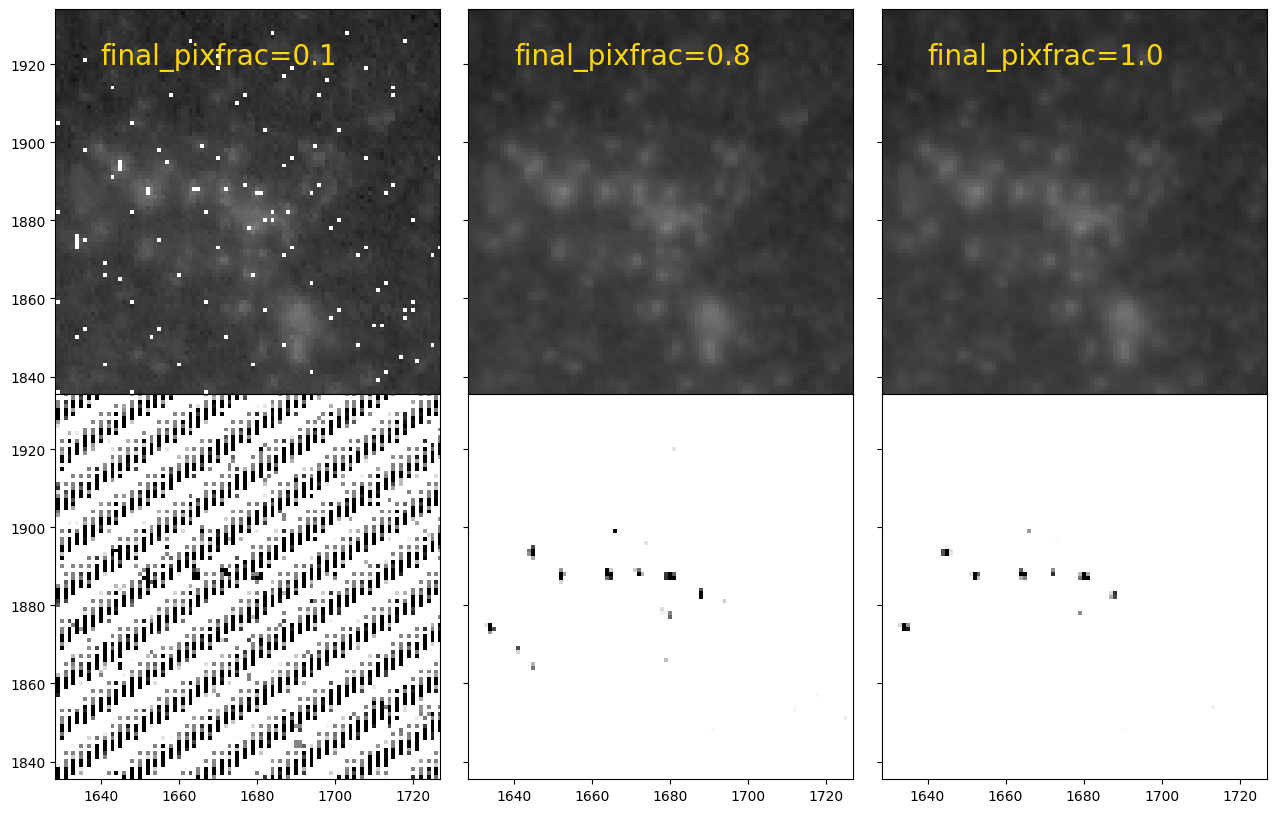

In [9]:
with fits.open('f160w_0.1_drz.fits') as hdu1:
    sci1 = hdu1[1].data
    wht1 = hdu1[2].data
    
with fits.open('f160w_0.8_drz.fits') as hdu2:
    sci2 = hdu2[1].data
    wht2 = hdu2[2].data
    
with fits.open('f160w_1.0_drz.fits') as hdu3:
    sci3 = hdu3[1].data
    wht3 = hdu3[2].data

fig,ax = plt.subplots(2, 3, figsize=(16, 10), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

norm3 = ImageNormalize(wht2, vmin=400, vmax=600, stretch=LinearStretch())
ax[0, 0].imshow(sci1, norm=norm2, cmap='gray')
ax[0, 0].text(1640, 1920, 'final_pixfrac=0.1', fontsize='20', color='gold')
ax[0, 1].imshow(sci2, norm=norm2, cmap='gray')
ax[0, 1].text(1640, 1920, 'final_pixfrac=0.8', fontsize='20', color='gold')
ax[0, 2].imshow(sci3, norm=norm2, cmap='gray')
ax[0, 2].text(1640, 1920, 'final_pixfrac=1.0', fontsize='20', color='gold')
ax[1, 0].imshow(wht1, norm=norm3, cmap='gray')
ax[1, 1].imshow(wht2, norm=norm3, cmap='gray')
ax[1, 2].imshow(wht3, norm=norm3, cmap='gray')
ax[0, 0].set_xlim(radeclims.to_pixel(im2wcs)[0])
ax[0, 0].set_ylim(radeclims.to_pixel(im2wcs)[1])

This figure above shows the central region of the science and weight images produced by `final_pixfrac` values (left to right) of 0.1, 0.8 and 1.0. The top row is the science frame, the bottom is the weight image. The science image with the smallest `final_pixfrac` value of 0.1 shows a noisy background and holes in the image where no input pixels fall into the output grid because pixfrac is too small. Inspection of the weight map corresponding to the smallest `final_pixfrac` value shows many places with weights of zero, indicating that a `final_pixfrac` value of 0.1 is clearly too small and was only included in this example for illustrative purposes.

Another piece of information that can be useful is the amount of noise in the weight image. As suggested in the [HST Dither Handbook](http://www.stsci.edu/hst/HST_overview/documents/dither_handbook) Chapter 5 and in the [DrizzlePac Handbook](http://documents.stsci.edu/hst/HST_overview/documents/DrizzlePac/ch64.html#586267) Section 6.3.3, statistics performed on the drizzled weight image should yield a RMS/median value less than ~0.2. This threshold controls the trade-off between improving image resolution versus increasing background noise due to pixel resampling.
 
The figure below shows the RMS/median as a function of `final_pixfrac`. One should take care to use the same region in the weight image as the region where the object of interest is located in the science image. If one is using the entire image for scientific analysis, then one should measure the statistics of the weight image where there is more variance. 

Text(0.1, 0.35, '8 images')

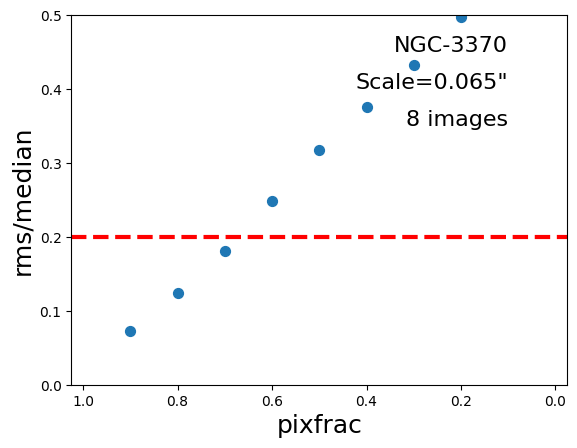

In [10]:
whtlist = glob.glob('f160w_0.[0-9]*drz.fits')

std_med = np.empty(len(whtlist), dtype=float)
fraclist = np.empty(len(whtlist), dtype=float)
xlims = radeclims.to_pixel(im1wcs)[0].astype(int)
ylims = radeclims.to_pixel(im1wcs)[1].astype(int)

#Loop that measures statistics, also some information gathering
for i, im in enumerate(whtlist):
    with fits.open(im) as hdu:
        hdr = hdu[0].header
        wht = hdu[2].data
    if i == 0:
        target = hdr['TARGNAME']
        scale = str(hdr['D001SCAL'])
        nimg = hdr['NDRIZIM']
    wht_std = np.std(wht[ylims[0] : ylims[1], xlims[0] : xlims[1]])
    wht_med = np.median(wht[ylims[0] : ylims[1], xlims[0] : xlims[1]])
    std_med[i] = wht_std / wht_med
    fraclist[i] = hdr['D001PIXF']

#Plotting commands              
plt.clf()
plt.xlim(1.025, -0.025)
plt.ylim(0., 0.5)
plt.scatter(fraclist, std_med, s=50)
plt.axhline(0.2, ls='--', lw=3, c='r')
plt.xlabel('pixfrac', fontsize=18)
plt.ylabel('rms/median', fontsize=18)
plt.text(0.1, 0.45, target, fontsize=16, horizontalalignment='right')
plt.text(0.1, 0.40, 'Scale=' + str(scale) + '"', fontsize=16, horizontalalignment='right')
plt.text(0.1, 0.35, str(nimg) + ' images', fontsize=16, horizontalalignment='right')

The RMS/median increases steadily up to pixfrac of 0.6, where there is a change in the slope of the function, indicating that something odd might be happening beyond that point. Even though the RMS remains below 20% of the median all the way to `final_pixfrac` of 0.1, the higher slope in the curve combined with the information from inspection of the science images themselvse (the evidence of holes) indicates that the pixfrac should remain >0.6. 

## 6. Final thoughts

The `final_pixfrac` value has to be small enough to avoid degrading the combined output image, but large enough that when all images are "dropped" onto the final frame, coverage of the output frame is fairly uniform. In general, `final_pixfrac` should be slightly larger than the final output scale to allow some "spillover" to adjacent pixels. This will help avoid "holes" in the final product when a given pixel has been flagged as "bad" in several frames. As a rule of thumb, statistics performed on the drizzled weight image in the region of interest should yield an RMS value (standard deviation) that is less than 20% of the median value. This threshold is a balance between the benefits of improving the image resolution at the expense of increasing noise in the background.

## About this Notebook

    Author: R. Avila, STScI ACS Team  
    Updated: December 12, 2018